In [10]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from typing import Tuple, List
import torch
import torch.nn as nn
import time
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import DataLoader, random_split


class CustomPoseDataset(Dataset):
    def __init__(self, image_dir: str, csv_file: str):
        self.image_dir = image_dir
        self.transform = transforms.Compose([
                                        transforms.Resize((64, 64), interpolation=Image.BICUBIC),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.45, 0.45, 0.45), std=(0.25, 0.25, 0.25)),
                                        ])

        self.data = pd.read_csv(csv_file)
        self.image_files = self.data['NAME'].tolist()
        
        data = self.data.drop(columns=['Unnamed: 0','NAME', 'Activity', 'Category', 'Scale',
                                             'pelvis_X', 'pelvis_Y', 'thorax_X', 'thorax_Y'])
       
        self.points = data.values.tolist()

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = Image.open(image_path).convert('RGB')

        original_width, original_height = image.size  

        points = self.points[idx]
        points = torch.tensor(points, dtype=torch.float32)

        points[::2] *= (64 / original_width)  
        points[1::2] *= (64 / original_height) 

        image = self.transform(image)

        return image, points


In [11]:
dataset = CustomPoseDataset(
    image_dir='/kaggle/input/mpii-dataset-for-python/dataset/images',
    csv_file='/kaggle/input/mpii-dataset-for-python/dataset/mpii_dataset.csv'
)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


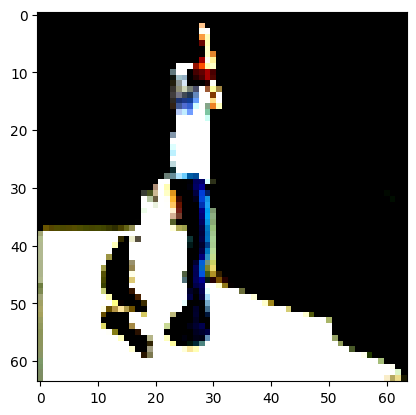

In [12]:
image, points = dataset[1000]
plt.imshow((image).permute((1,2,0)))

In [13]:
BODY_KEYPOINTS = 14

class MyPoseNet(nn.Module):
    def __init__(self):
        super(MyPoseNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.feature_size = self._calculate_feature_size()
        
        self.fc1 = nn.Linear(in_features=self.feature_size, out_features=256)  
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=256, out_features=BODY_KEYPOINTS * 2) 
        
    def _calculate_feature_size(self):
        dummy_input = torch.zeros(1, 3, 64, 64)
        x = self.relu1(self.bn1(self.conv1(dummy_input)))
        x = self.pool1(x)
        
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        return x.size(1)
    
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        
        x = self.relu3(self.conv3(x))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)  
        
        return x



In [14]:
def test_loop(dataloader, model, loss_fn, device, threshold=30.0, num_keypoints=14):
    model.eval() 
    
    total_loss = 0.0
    num_correct = 0
    total_points = 0
        
    with torch.no_grad():  
        for images, keypoints in dataloader:
            images, keypoints = images.to(device), keypoints.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, keypoints)
            total_loss += loss.item()
          
            distance = (outputs - keypoints).norm(dim=1)  
            num_correct += (distance < threshold).sum().item()
            total_points += keypoints.size(0) 
    
    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = num_correct / total_points  
    
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss

In [15]:
from tqdm import tqdm

def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train() 
    running_loss = 0.0
    for images, keypoints in tqdm(dataloader, desc="Training", leave=False):
        images, keypoints = images.to(device), keypoints.to(device)
       
        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, keypoints)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_loss = running_loss / len(dataloader.dataset)
    print(f'Train Loss: {avg_loss:.4f}')
    return avg_loss


In [16]:
def plot_predictions(images, keypoints, predictions, num_keypoints, epoch):
    num_images = len(images)
    num_samples = min(3, num_images)  

    indices = random.sample(range(num_images), num_samples)
    
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axs = [axs] 

    for i, idx in enumerate(indices):
        ax = axs[i]
        image = images[idx].cpu().numpy().transpose(1, 2, 0)  
        image = (image - image.min()) / (image.max() - image.min())  
        
        ax.imshow(image)
        ax.scatter(keypoints[idx, ::2].cpu().numpy(), keypoints[idx, 1::2].cpu().numpy(), c='r', label='True Keypoints')
        ax.scatter(predictions[idx, ::2].cpu().numpy(), predictions[idx, 1::2].cpu().numpy(), c='b', label='Predicted Keypoints')
        ax.legend()
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'epoch_{epoch+1}_predictions.png')
    plt.show()
    

In [17]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=100, device='cpu'):
    model.to(device)
    
    start_time = time.time()  
    
    test_loss_per_epoch = []
    train_loss_per_epoch = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        epoch_start_time = time.time()
        
        train_loss = train_loop(train_dataloader, model, criterion, optimizer, device)
        test_loss = test_loop(test_dataloader, model, criterion, device)

        train_loss_per_epoch.append(train_loss)  
        test_loss_per_epoch.append(test_loss) 
        
        with torch.no_grad():
            images, keypoints = next(iter(test_dataloader)) 
            images, keypoints = images.to(device), keypoints.to(device)
            predictions = model(images)  
        
        plot_predictions(images, keypoints, predictions, BODY_KEYPOINTS, epoch)
        
        epoch_end_time = time.time()        
        epoch_duration = epoch_end_time - epoch_start_time  
        print(f'Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds', flush=True)

    total_training_time = time.time() - start_time 
    print(f'Training complete. Total time: {total_training_time:.2f} seconds', flush=True)
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_epochs), train_loss_per_epoch, label='Training Loss')
    plt.plot(range(num_epochs), test_loss_per_epoch, label='Test Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/100


Train Loss: 1.3521
Test Loss: 0.8720, Accuracy: 0.0144


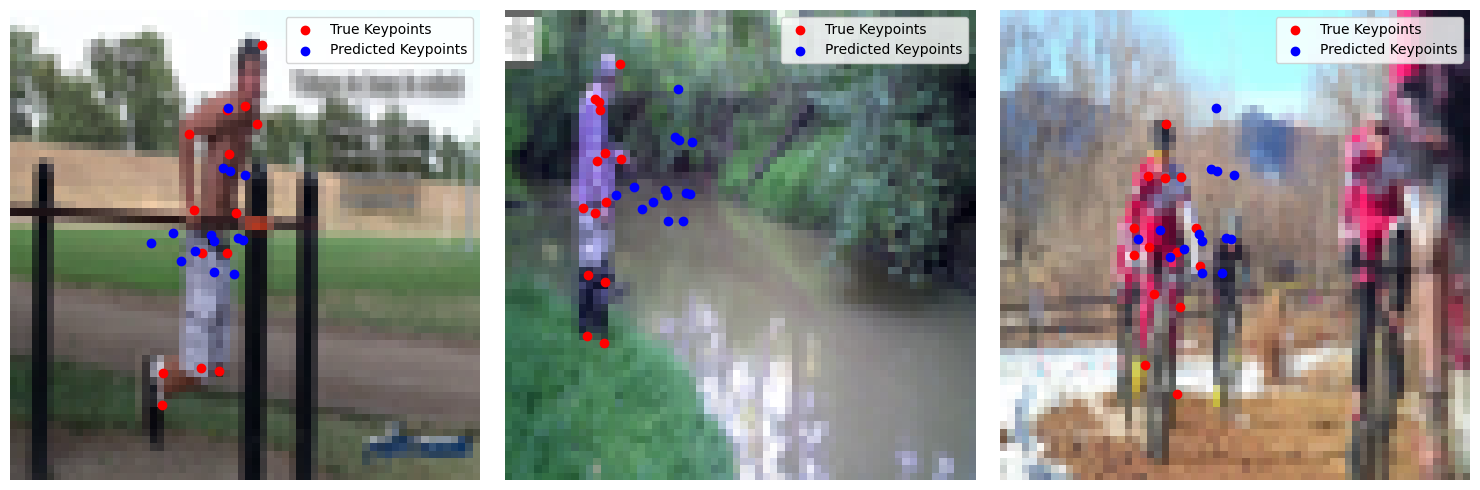

Epoch 1/100 completed in 500.40 seconds
Epoch 2/100


Train Loss: 0.8330
Test Loss: 0.8279, Accuracy: 0.0173


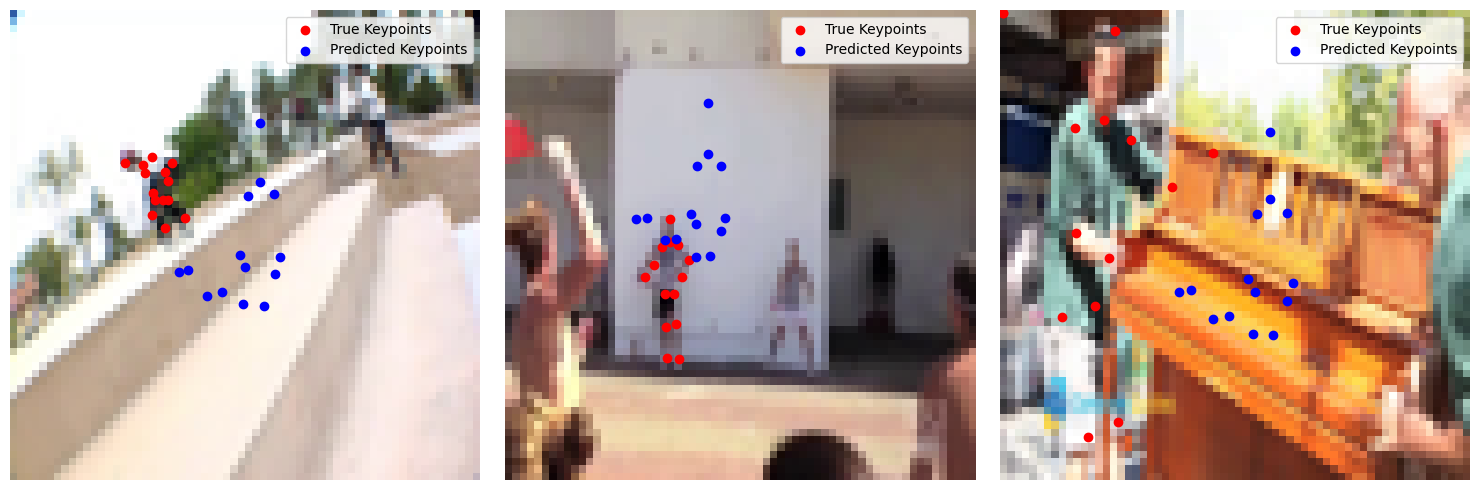

Epoch 2/100 completed in 491.45 seconds
Epoch 3/100


Train Loss: 0.8024
Test Loss: 0.8225, Accuracy: 0.0164


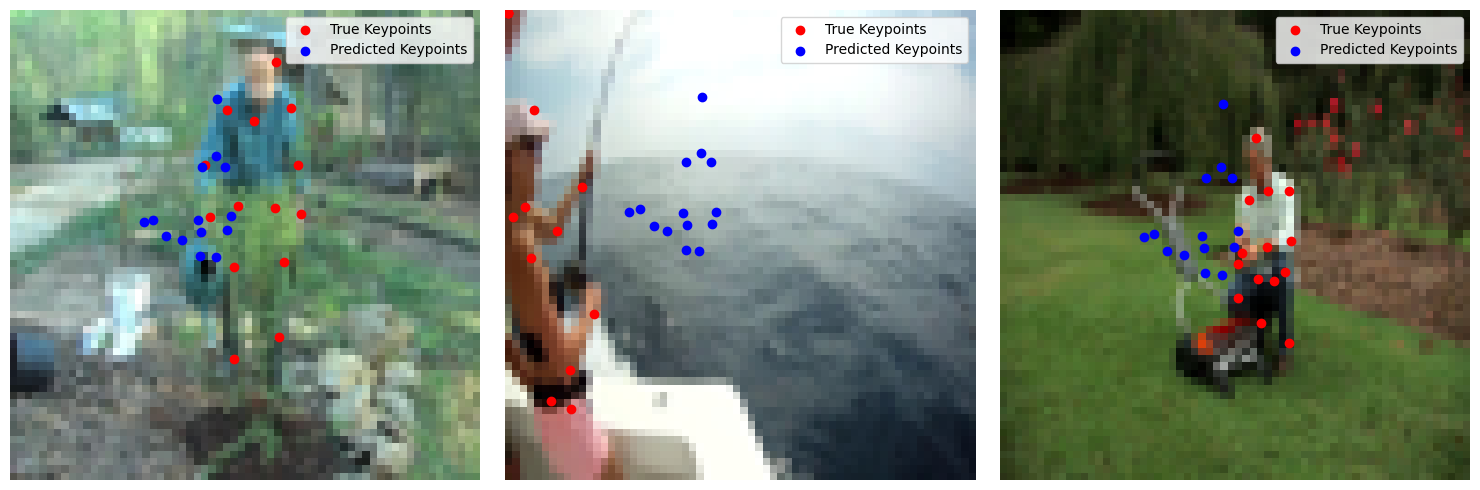

Epoch 3/100 completed in 482.01 seconds
Epoch 4/100


Train Loss: 0.7801
Test Loss: 0.7834, Accuracy: 0.0222


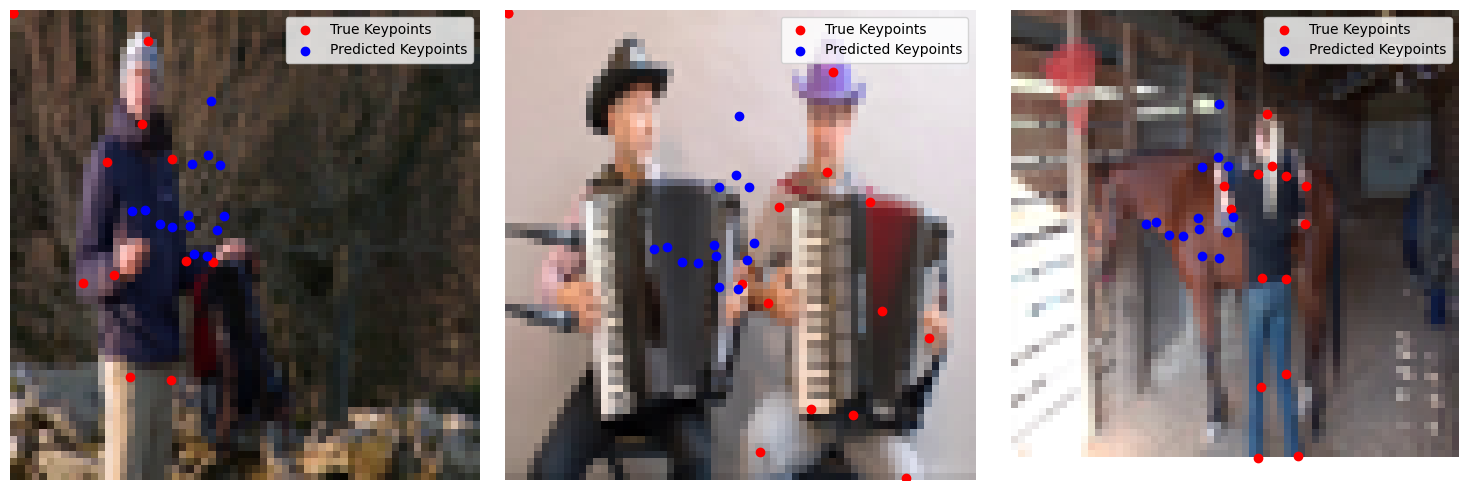

Epoch 4/100 completed in 489.19 seconds
Epoch 5/100


Train Loss: 0.7573
Test Loss: 0.7684, Accuracy: 0.0230


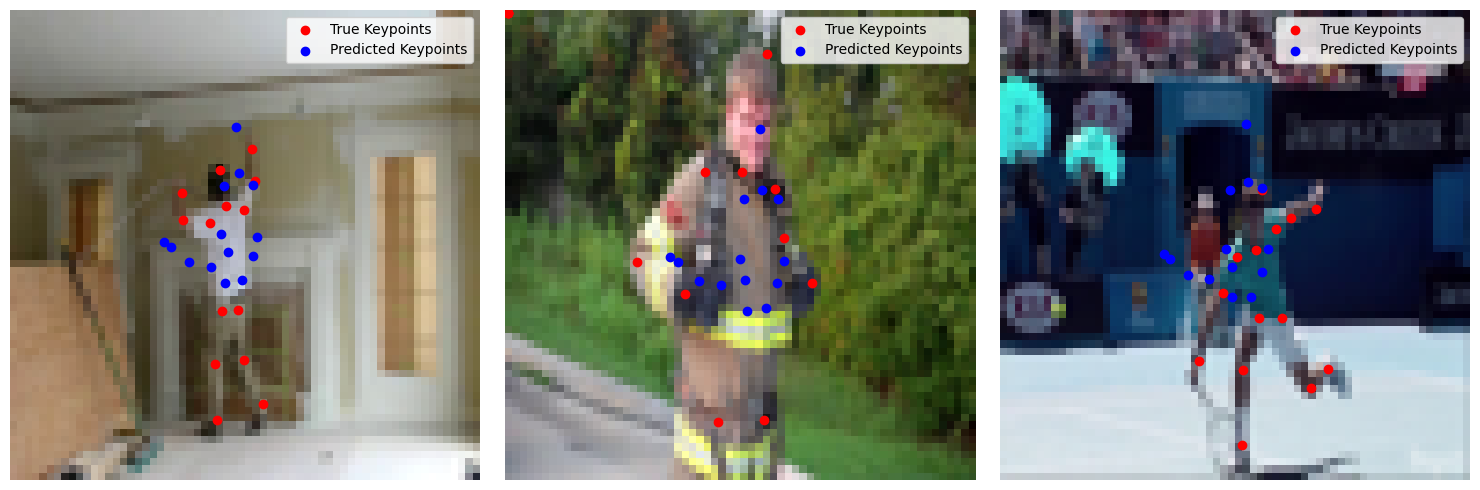

Epoch 5/100 completed in 490.49 seconds
Epoch 6/100


Train Loss: 0.7317
Test Loss: 0.7297, Accuracy: 0.0524


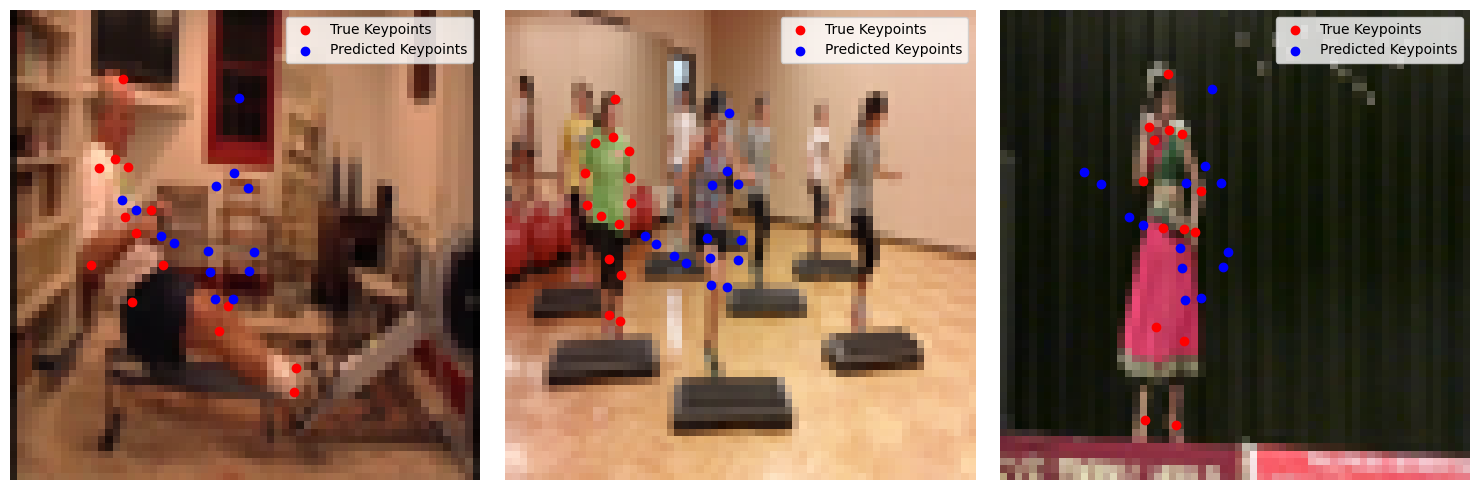

Epoch 6/100 completed in 495.19 seconds
Epoch 7/100


Train Loss: 0.7097
Test Loss: 0.7286, Accuracy: 0.0777


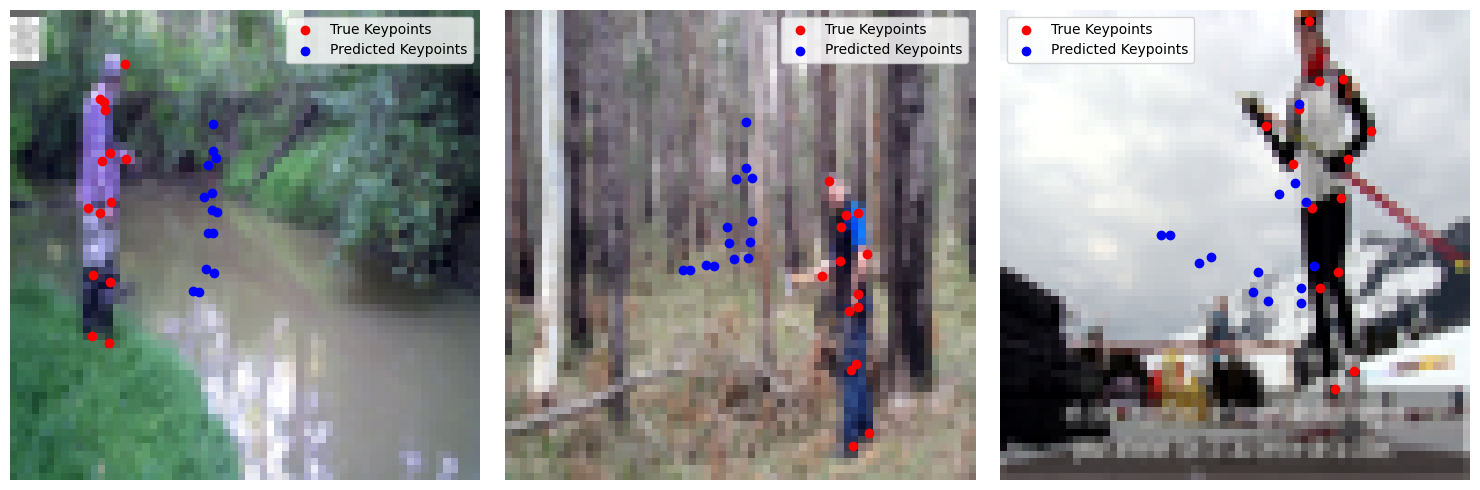

Epoch 7/100 completed in 491.33 seconds
Epoch 8/100


Train Loss: 0.6988
Test Loss: 0.7103, Accuracy: 0.0717


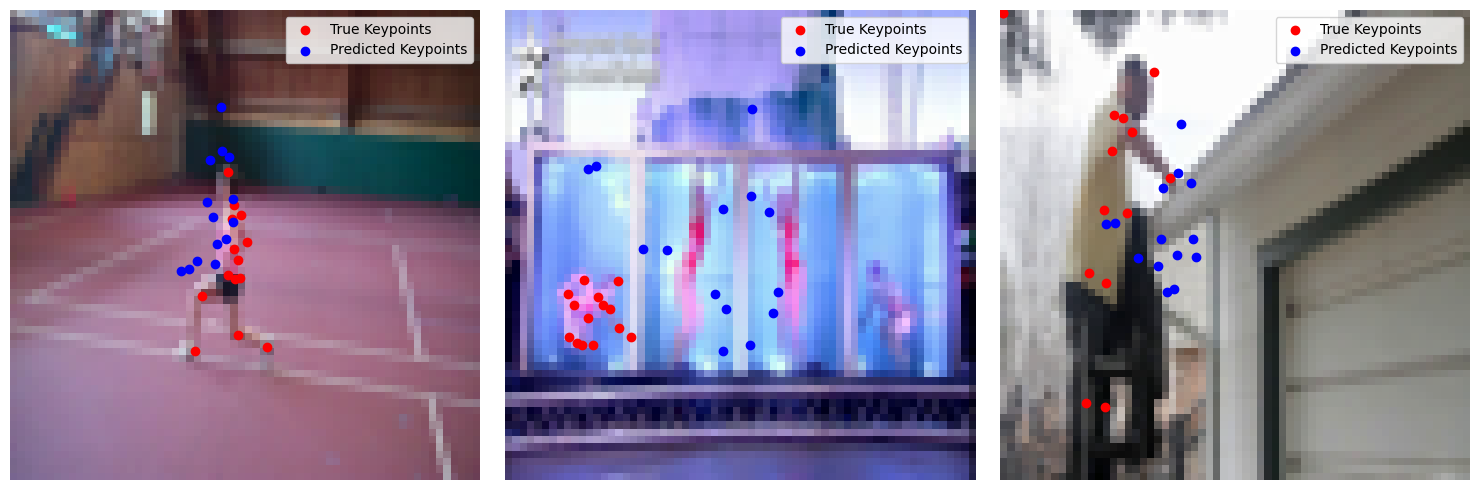

Epoch 8/100 completed in 485.86 seconds
Epoch 9/100


Train Loss: 0.6847
Test Loss: 0.6935, Accuracy: 0.0866


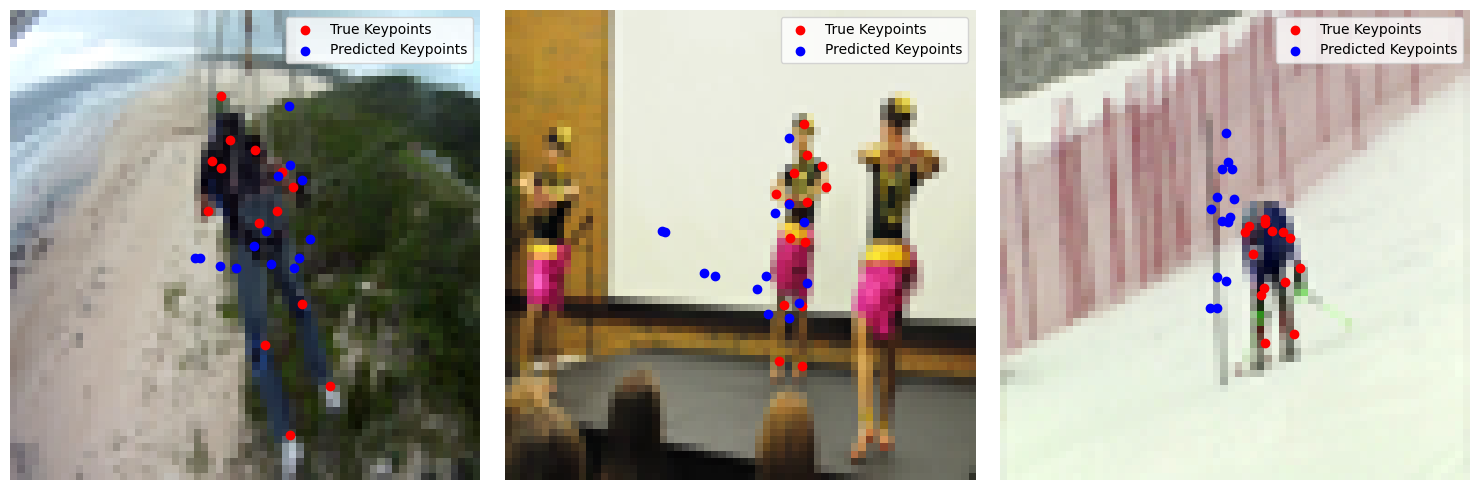

Epoch 9/100 completed in 489.33 seconds
Epoch 10/100


Train Loss: 0.6818
Test Loss: 0.6988, Accuracy: 0.0748


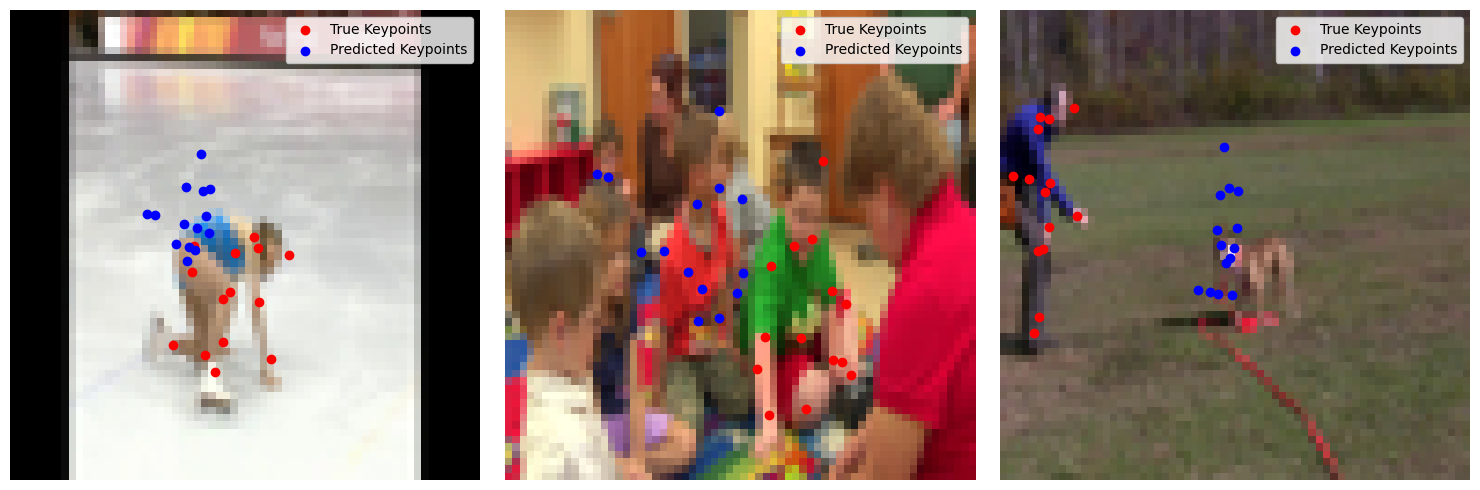

Epoch 10/100 completed in 493.88 seconds
Epoch 11/100


Train Loss: 0.6766
Test Loss: 0.7189, Accuracy: 0.0964


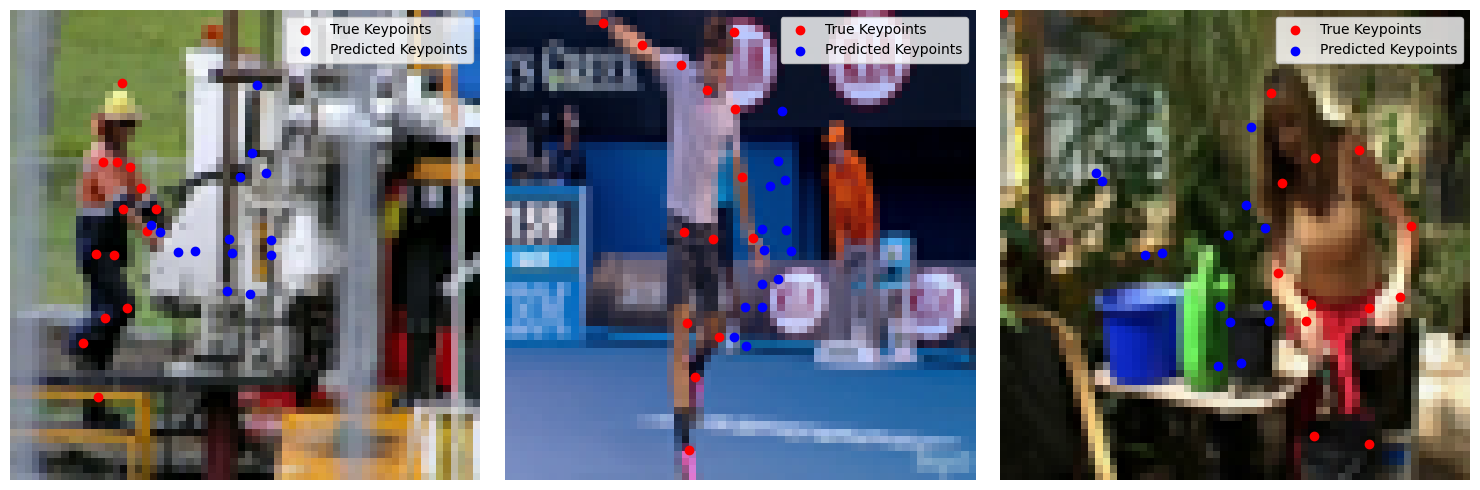

Epoch 11/100 completed in 480.89 seconds
Epoch 12/100


Train Loss: 0.6708
Test Loss: 0.6886, Accuracy: 0.0863


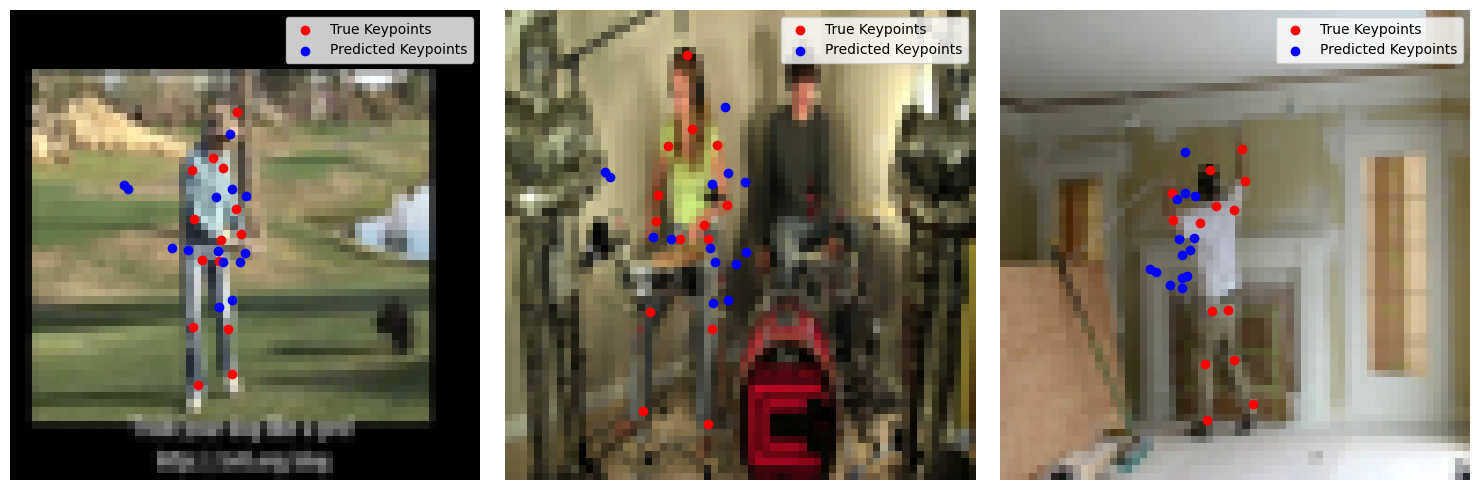

Epoch 12/100 completed in 484.37 seconds
Epoch 13/100


Train Loss: 0.6606
Test Loss: 0.6778, Accuracy: 0.0906


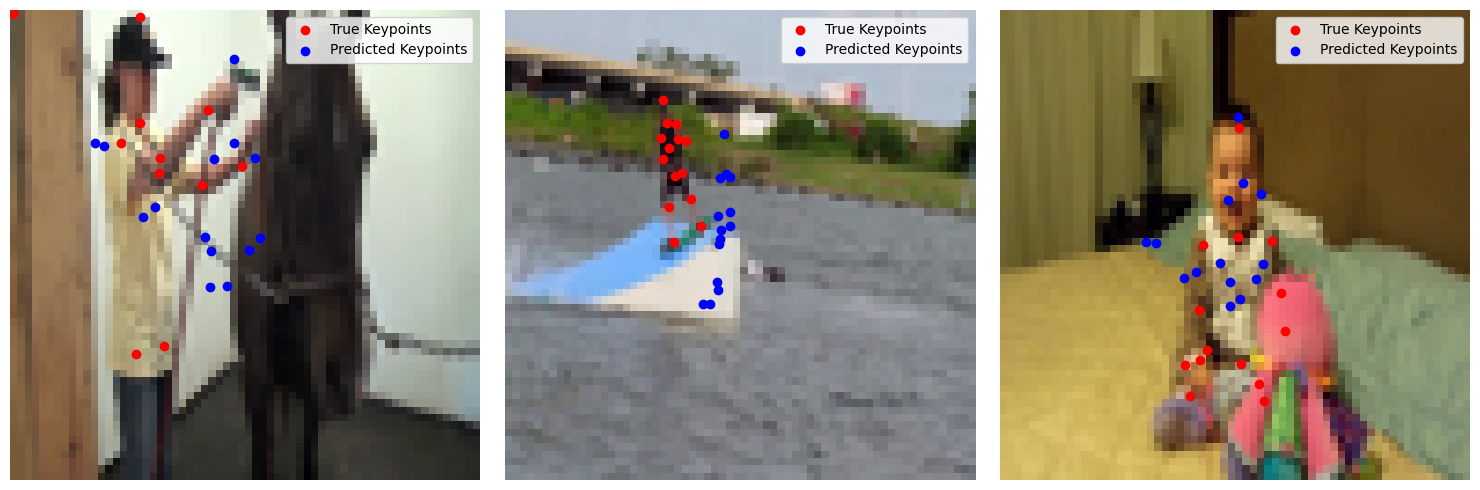

Epoch 13/100 completed in 498.33 seconds
Epoch 14/100


Train Loss: 0.6540
Test Loss: 0.6739, Accuracy: 0.1240


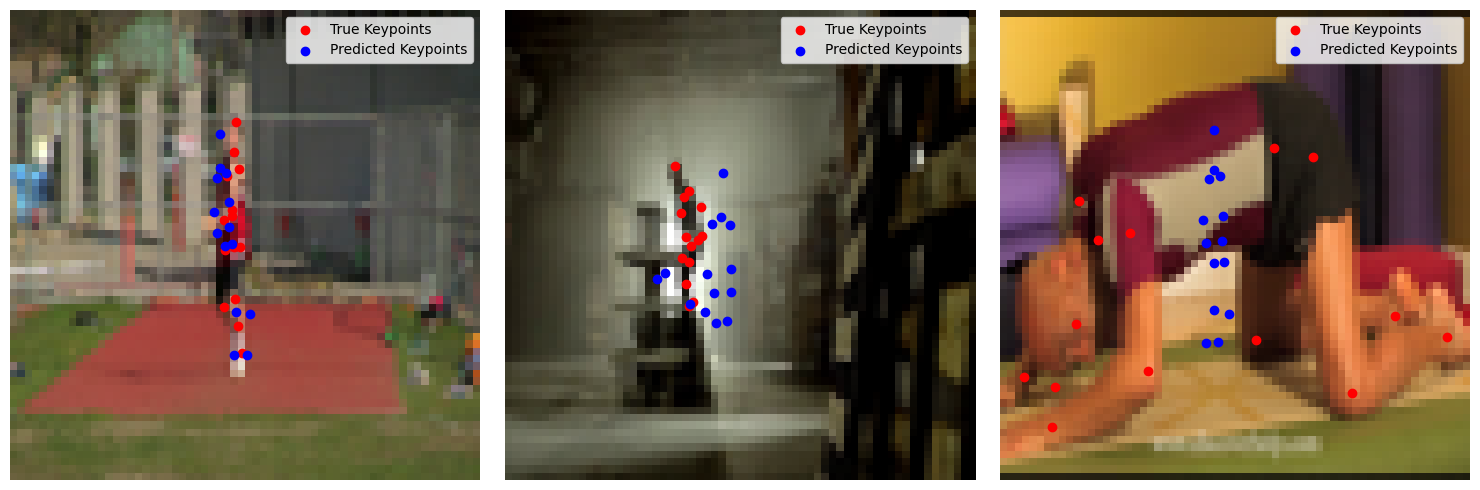

Epoch 14/100 completed in 484.08 seconds
Epoch 15/100


Train Loss: 0.6476
Test Loss: 0.6672, Accuracy: 0.0970


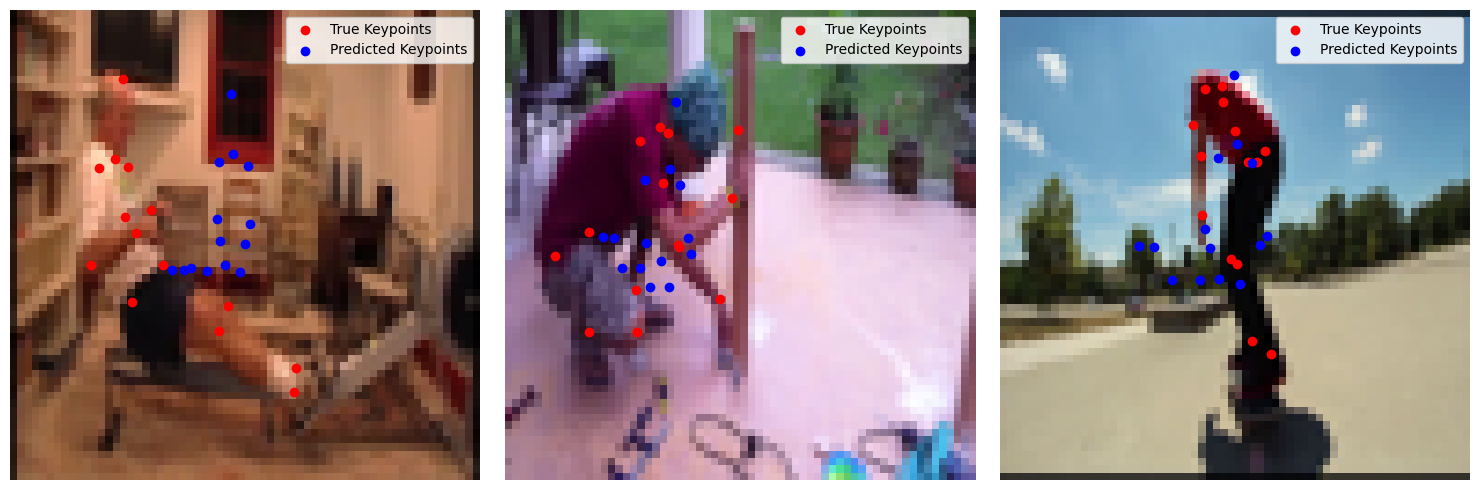

Epoch 15/100 completed in 482.42 seconds
Epoch 16/100


Train Loss: 0.6421
Test Loss: 0.6636, Accuracy: 0.1024


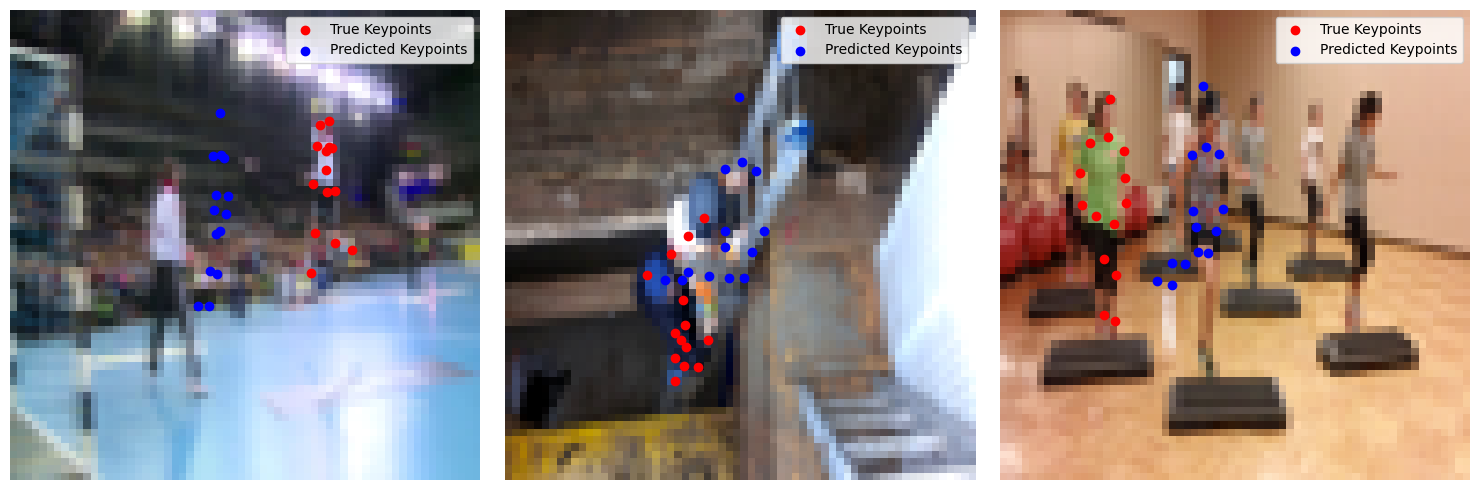

Epoch 16/100 completed in 493.82 seconds
Epoch 17/100


Train Loss: 0.6387
Test Loss: 0.6659, Accuracy: 0.0996


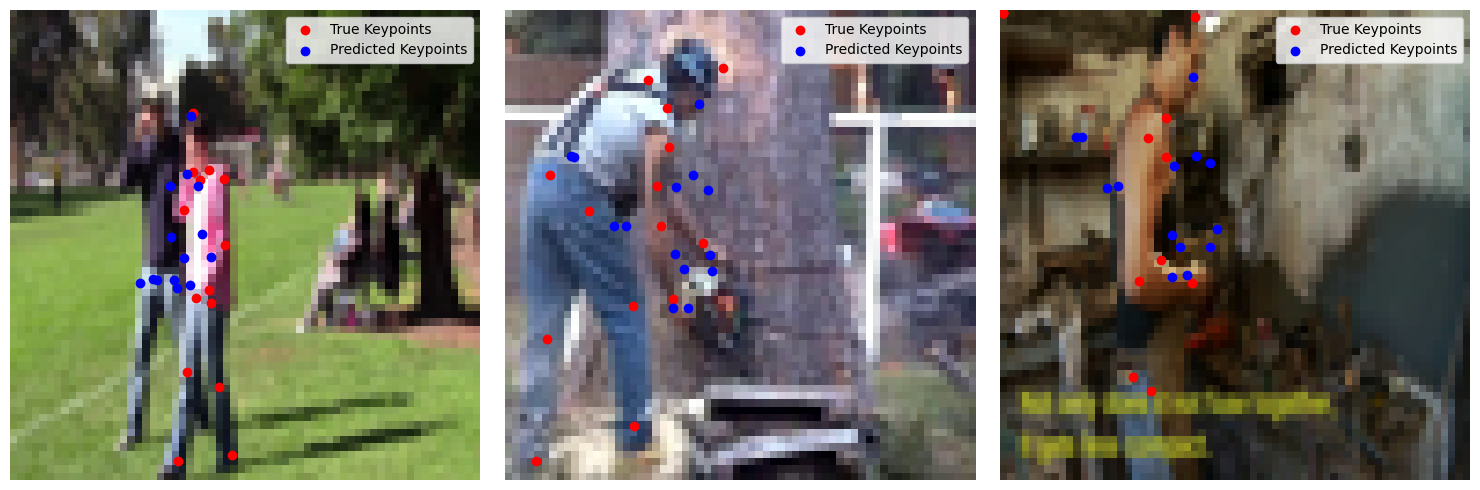

Epoch 17/100 completed in 485.47 seconds
Epoch 18/100


Train Loss: 0.6350
Test Loss: 0.6619, Accuracy: 0.1016


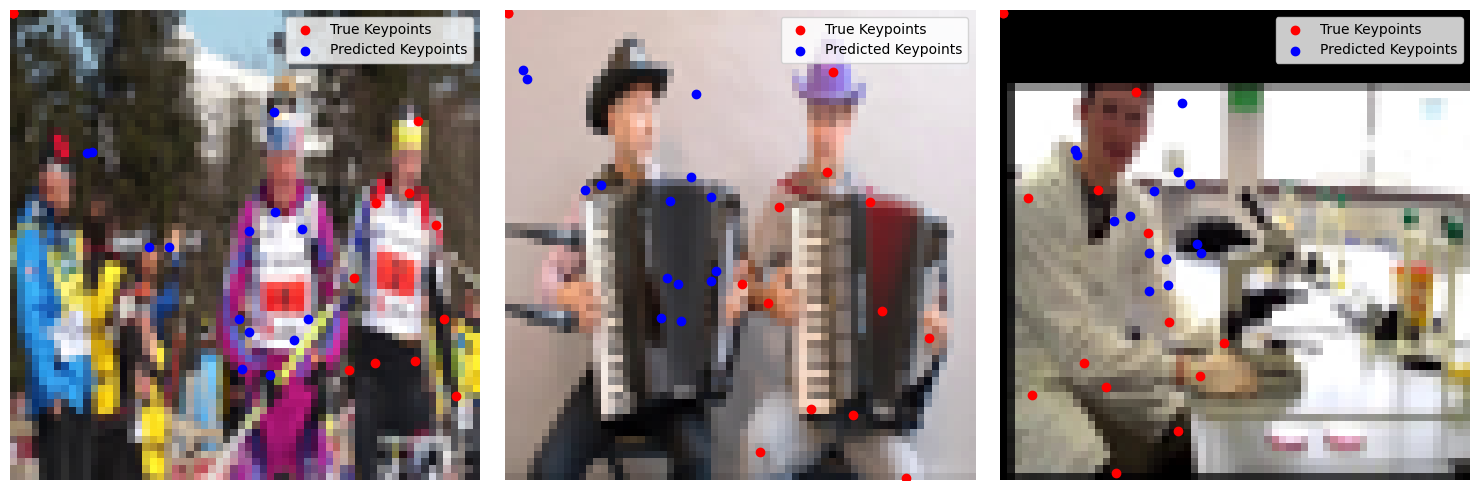

Epoch 18/100 completed in 487.70 seconds
Epoch 19/100


Train Loss: 0.6273
Test Loss: 0.6503, Accuracy: 0.1180


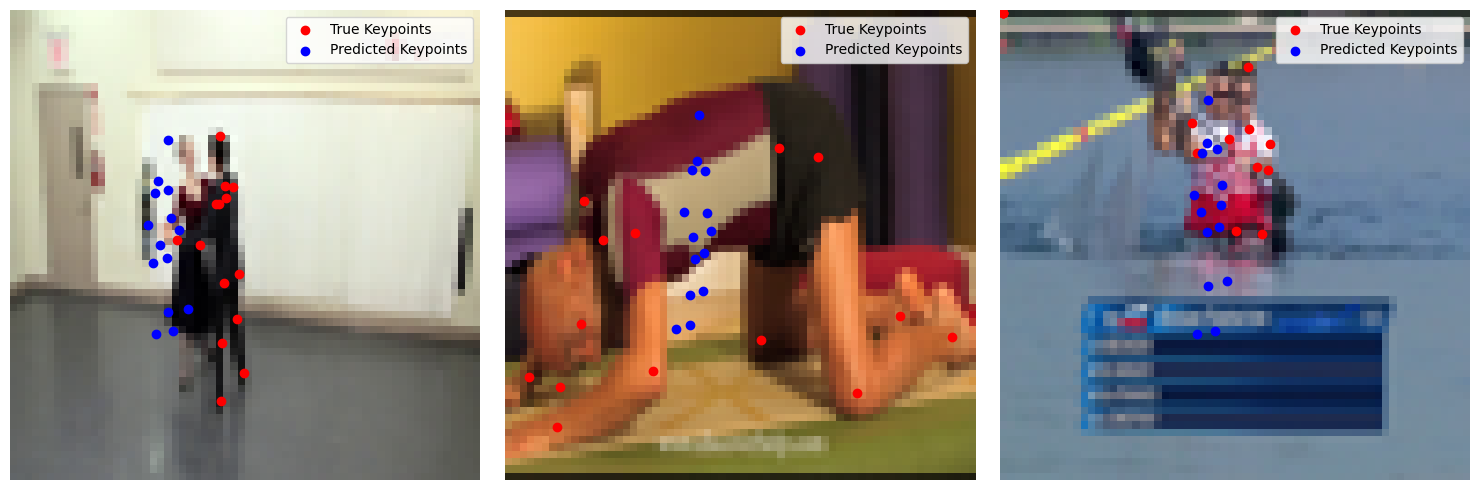

Epoch 19/100 completed in 491.02 seconds
Epoch 20/100


Train Loss: 0.6253
Test Loss: 0.6467, Accuracy: 0.1140


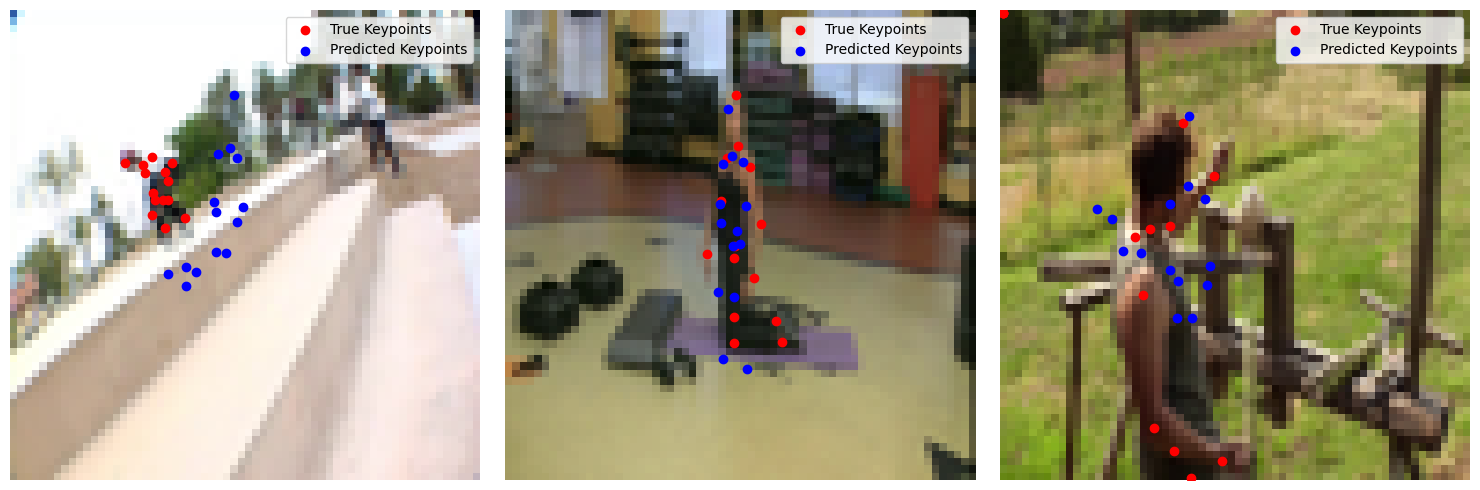

Epoch 20/100 completed in 492.42 seconds
Epoch 21/100


Train Loss: 0.6195
Test Loss: 0.6459, Accuracy: 0.1427


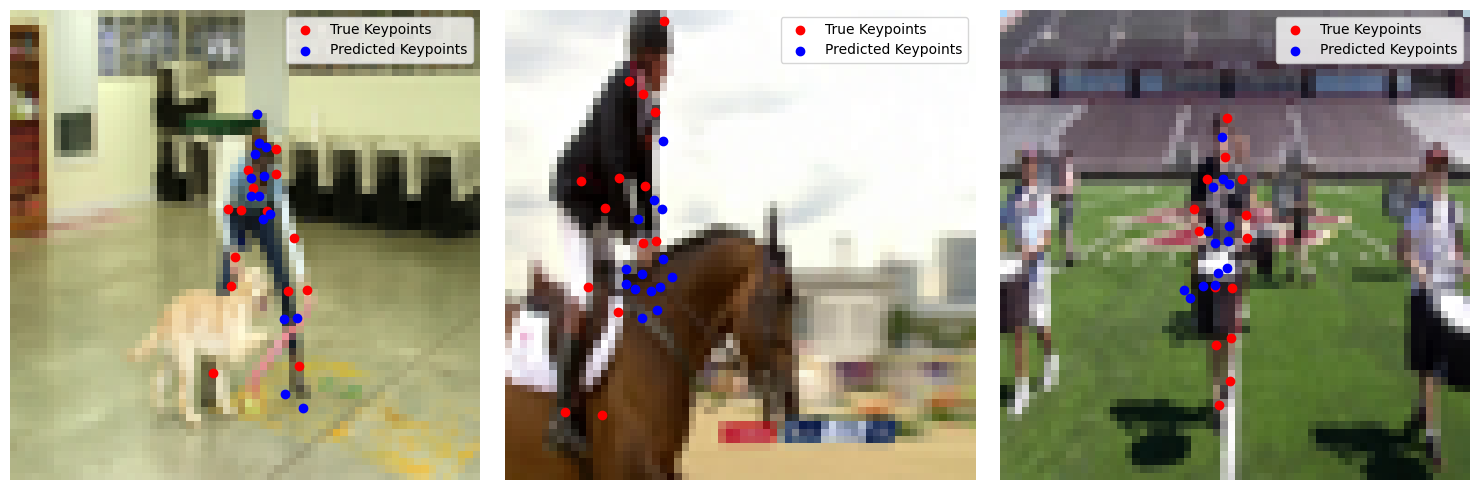

Epoch 21/100 completed in 492.78 seconds
Epoch 22/100


Train Loss: 0.6158
Test Loss: 0.6424, Accuracy: 0.1301


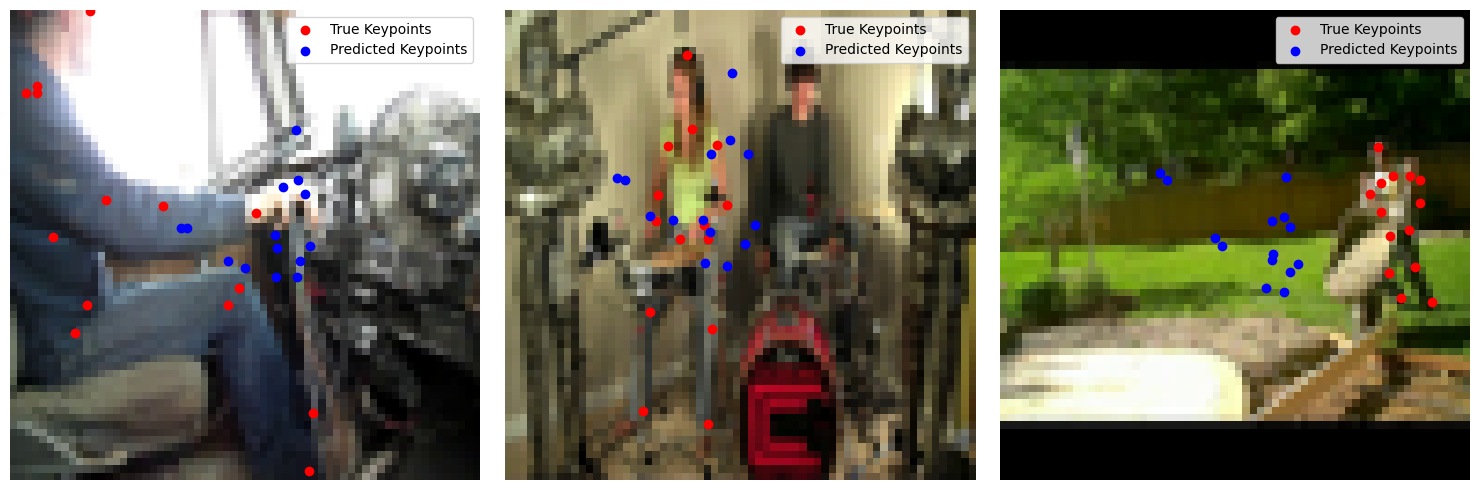

Epoch 22/100 completed in 492.38 seconds
Epoch 23/100


Train Loss: 0.6135
Test Loss: 0.6401, Accuracy: 0.1085


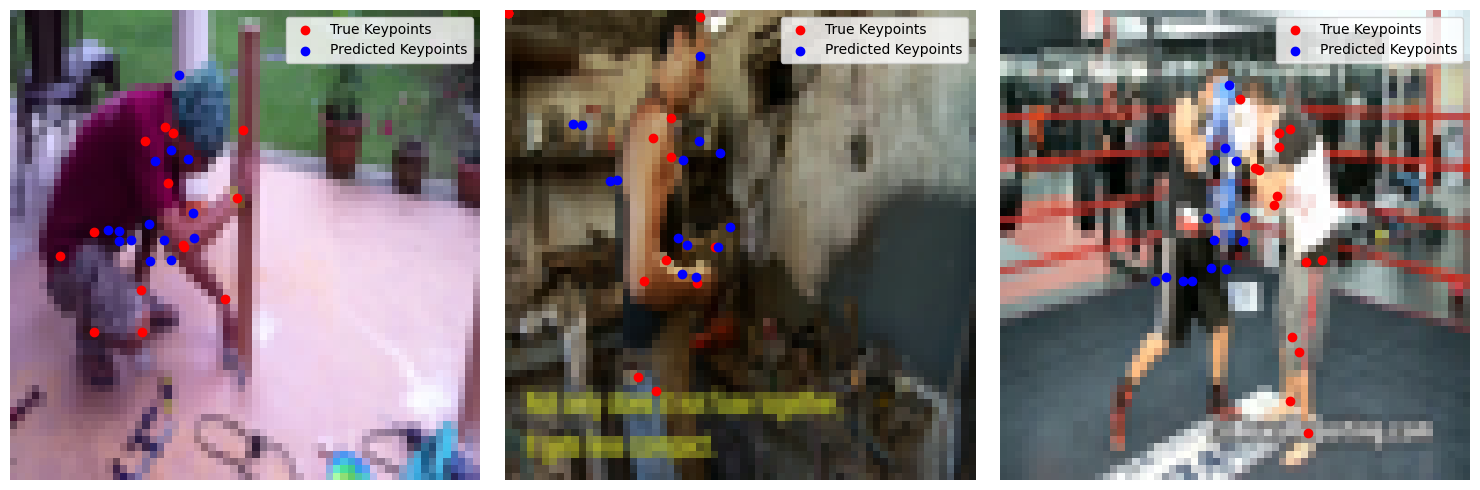

Epoch 23/100 completed in 490.77 seconds
Epoch 24/100


Train Loss: 0.6065
Test Loss: 0.6304, Accuracy: 0.1301


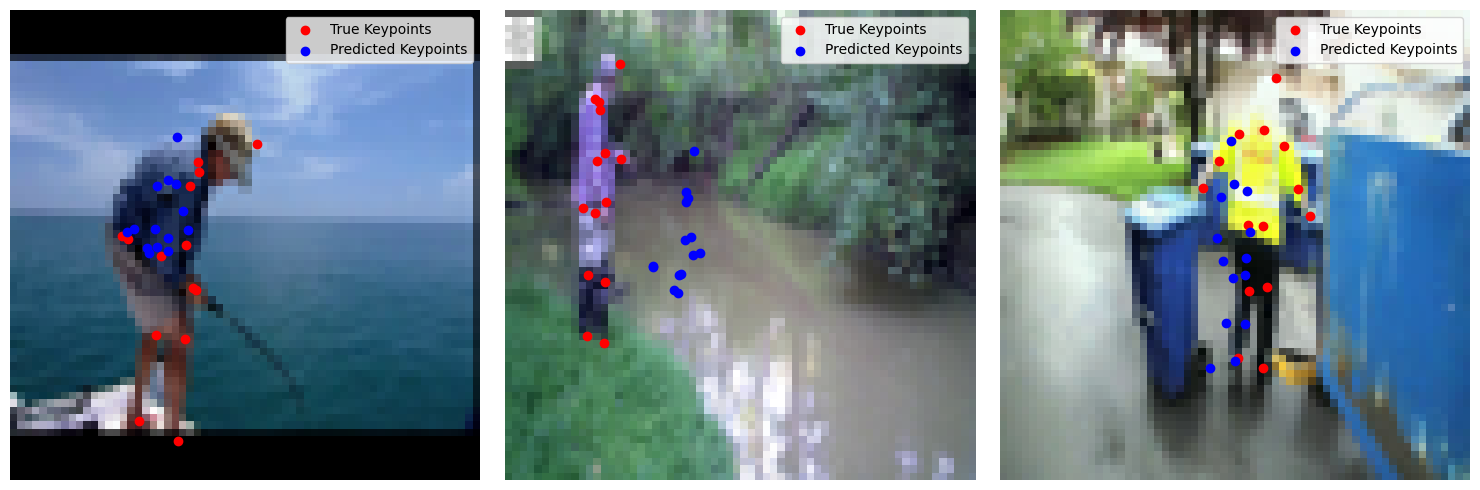

Epoch 24/100 completed in 491.61 seconds
Epoch 25/100


Train Loss: 0.6013
Test Loss: 0.6272, Accuracy: 0.1327


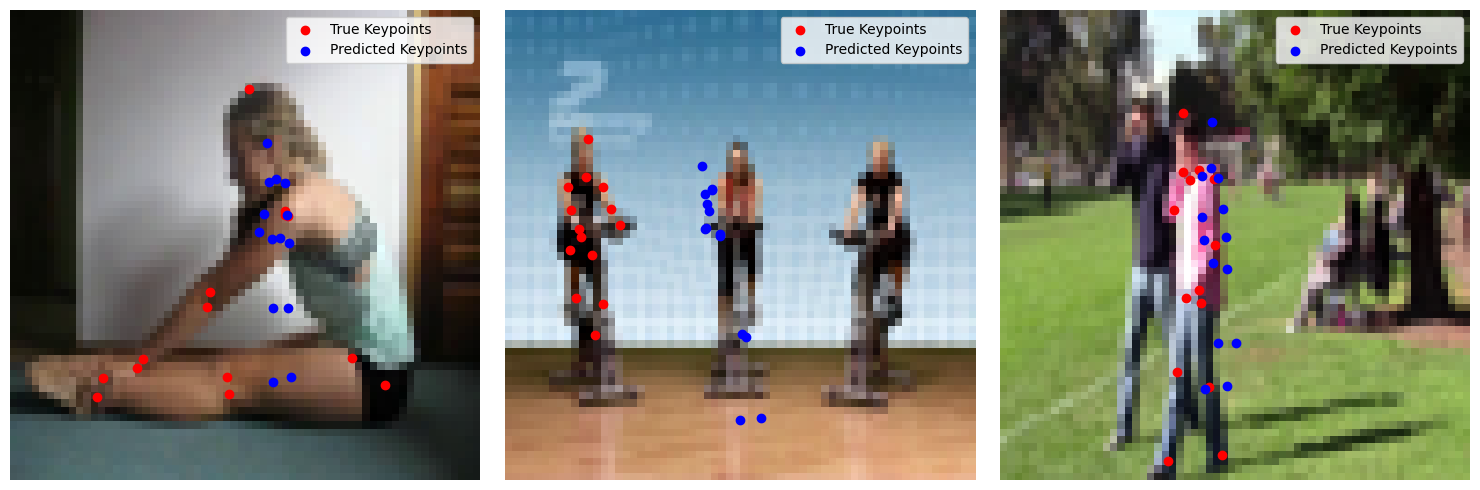

Epoch 25/100 completed in 489.29 seconds
Epoch 26/100


Train Loss: 0.5953
Test Loss: 0.6213, Accuracy: 0.1353


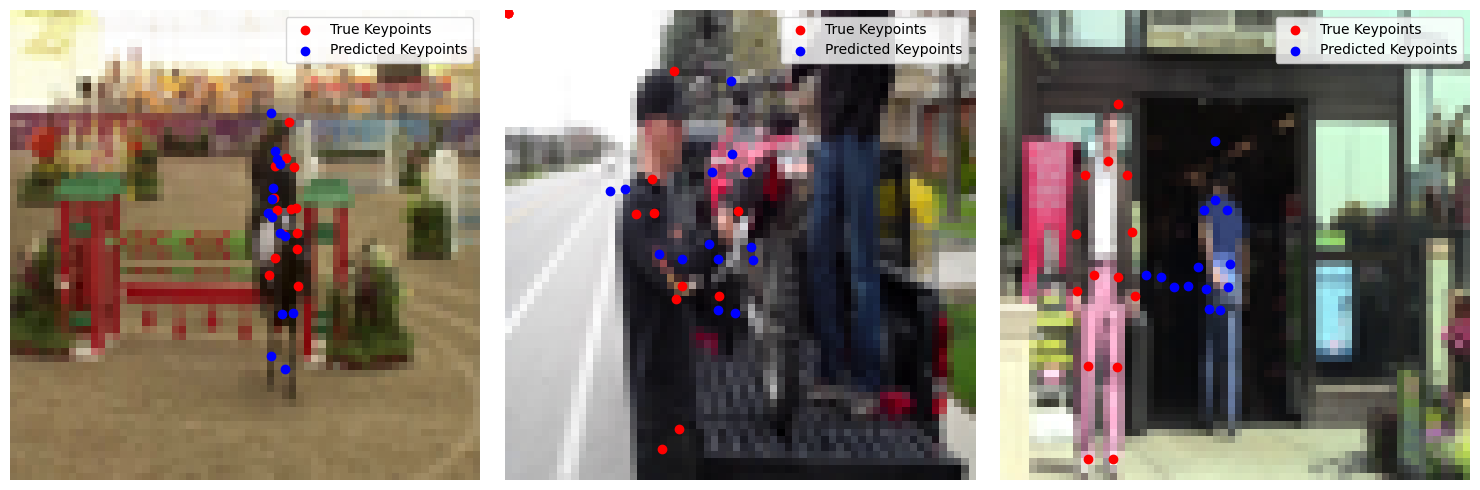

Epoch 26/100 completed in 495.46 seconds
Epoch 27/100


Train Loss: 0.5890
Test Loss: 0.6203, Accuracy: 0.1350


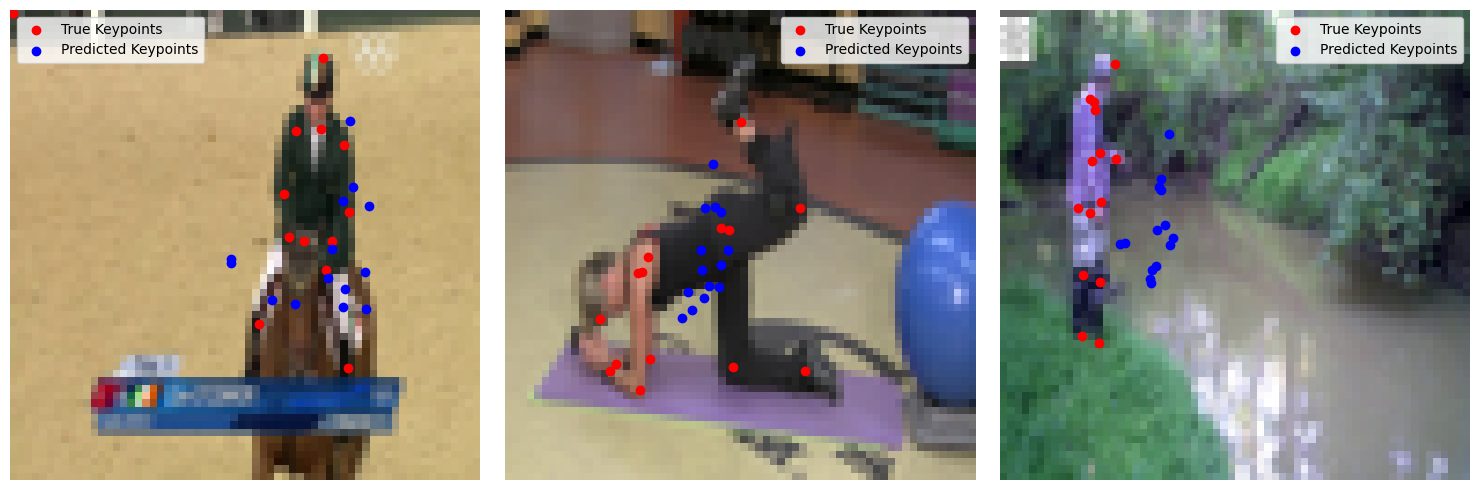

Epoch 27/100 completed in 481.27 seconds
Epoch 28/100


Train Loss: 0.5840
Test Loss: 0.6167, Accuracy: 0.1502


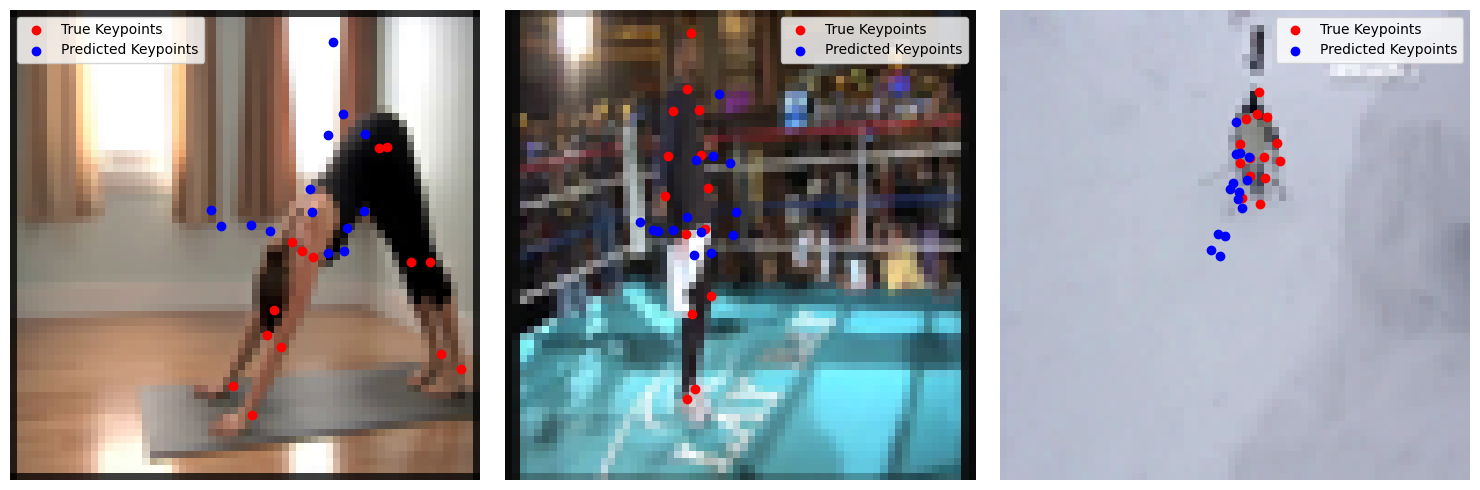

Epoch 28/100 completed in 489.00 seconds
Epoch 29/100


Train Loss: 0.5789
Test Loss: 0.6204, Accuracy: 0.1376


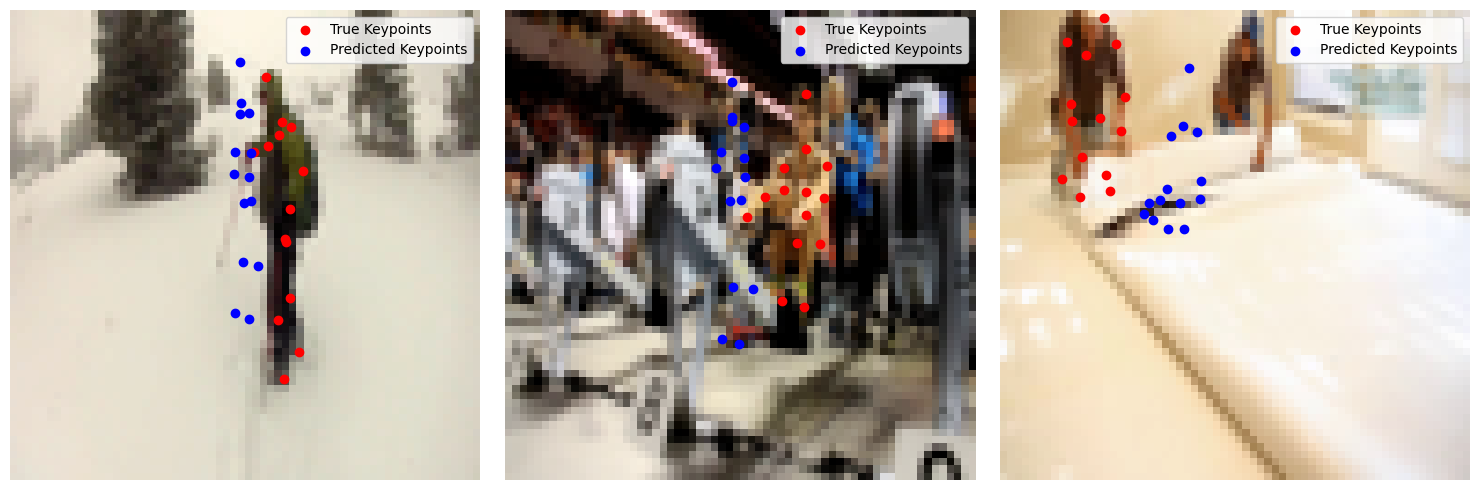

Epoch 29/100 completed in 504.19 seconds
Epoch 30/100


Train Loss: 0.5742
Test Loss: 0.6117, Accuracy: 0.1439


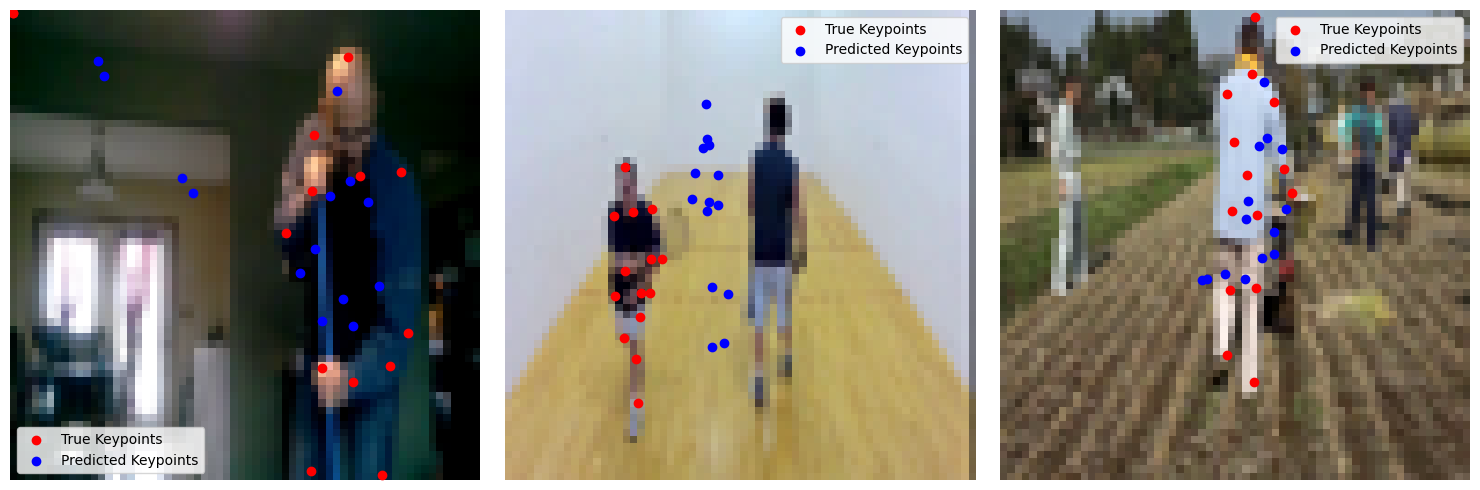

Epoch 30/100 completed in 515.99 seconds
Epoch 31/100


Train Loss: 0.5700
Test Loss: 0.6110, Accuracy: 0.1511


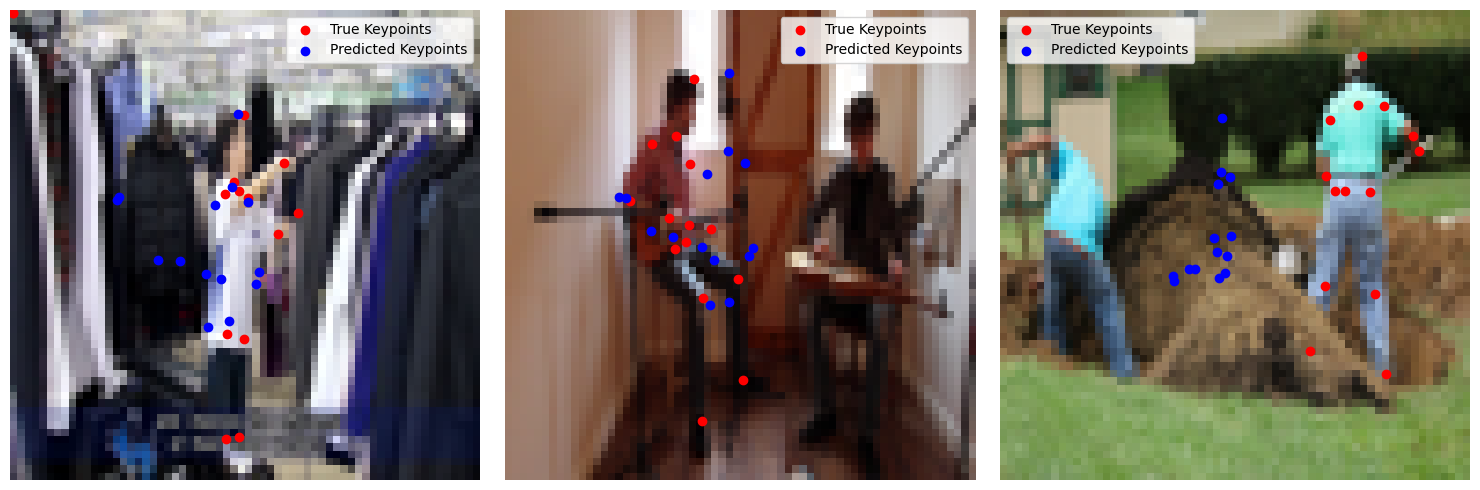

Epoch 31/100 completed in 517.67 seconds
Epoch 32/100


Train Loss: 0.5661
Test Loss: 0.6200, Accuracy: 0.1347


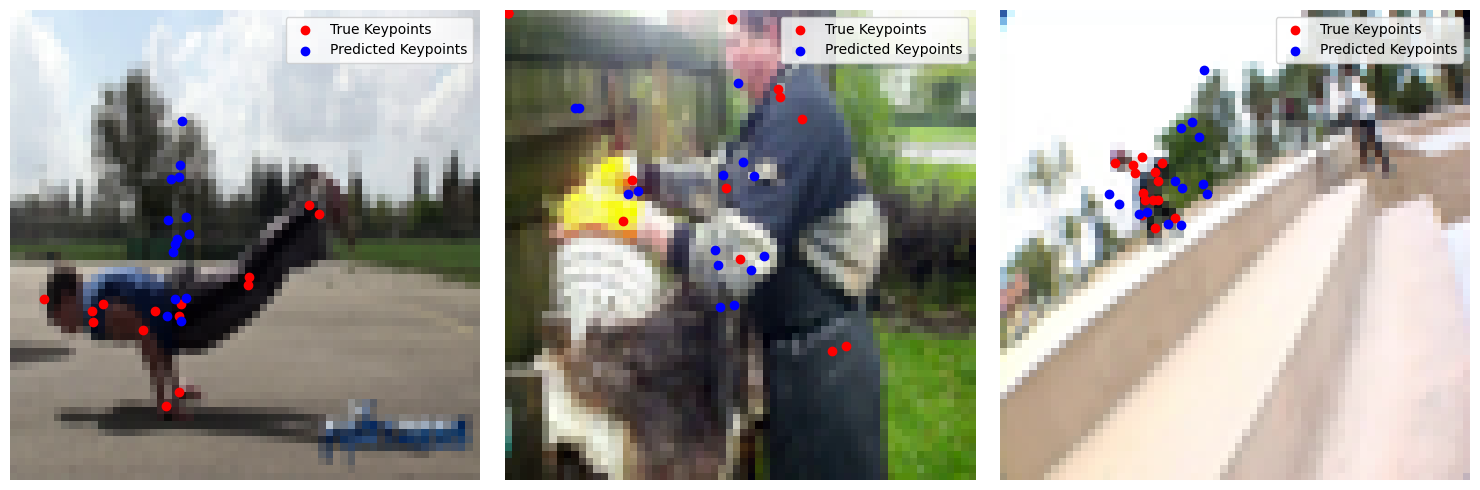

Epoch 32/100 completed in 529.45 seconds
Epoch 33/100


Train Loss: 0.5662
Test Loss: 0.6078, Accuracy: 0.1436


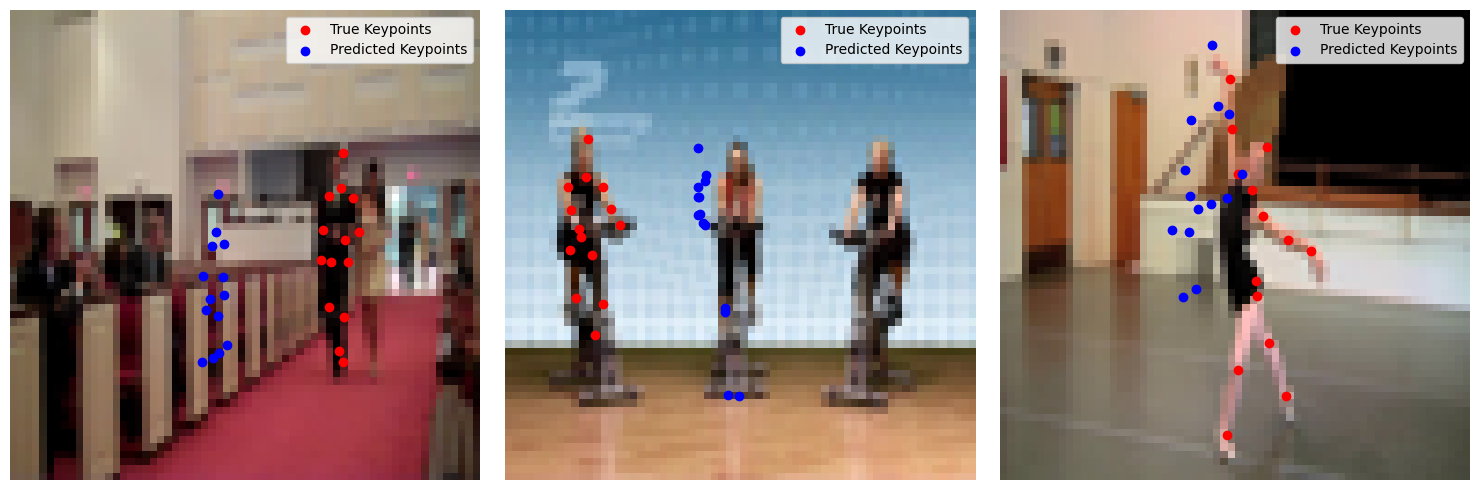

Epoch 33/100 completed in 525.28 seconds
Epoch 34/100


Train Loss: 0.5561
Test Loss: 0.6039, Accuracy: 0.1574


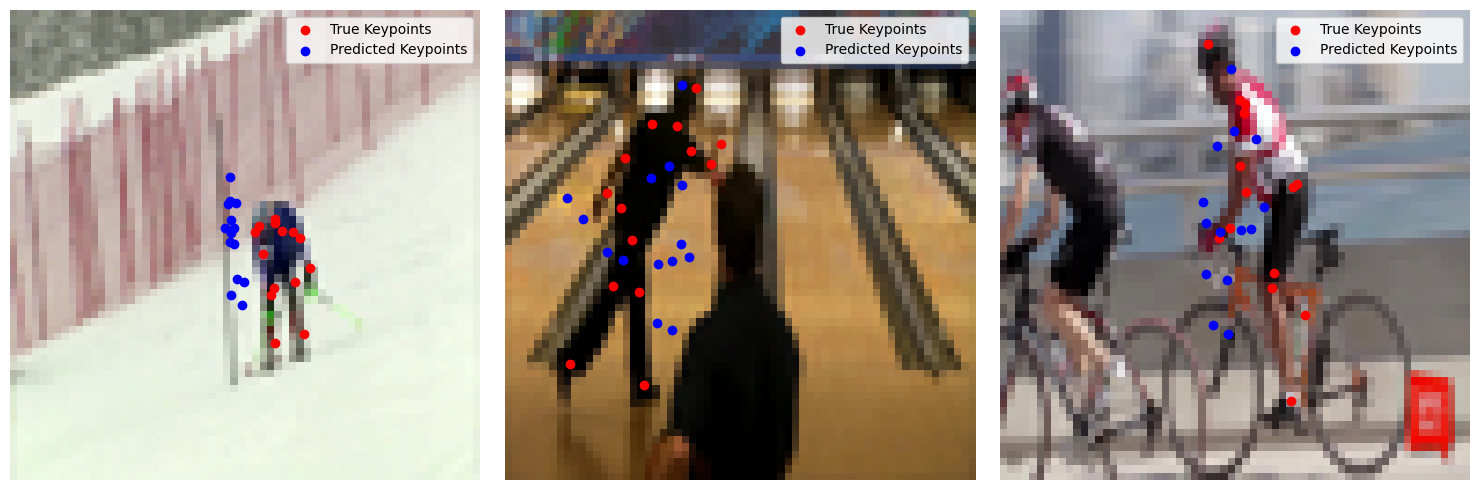

Epoch 34/100 completed in 533.04 seconds
Epoch 35/100


Train Loss: 0.5507
Test Loss: 0.6051, Accuracy: 0.1496


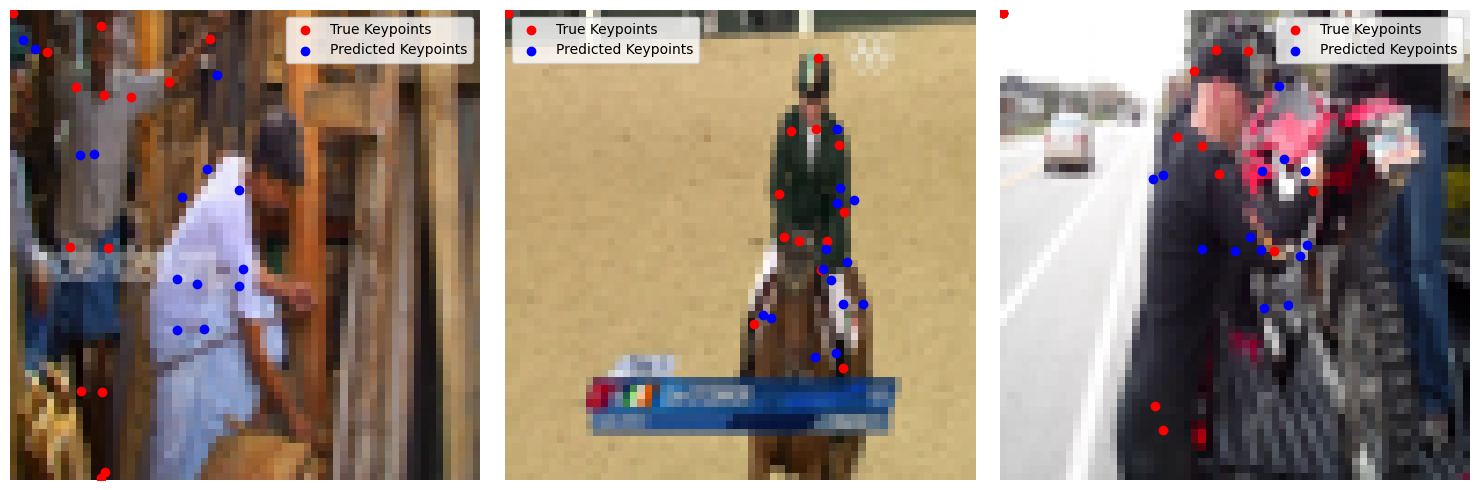

Epoch 35/100 completed in 531.15 seconds
Epoch 36/100


Train Loss: 0.5449
Test Loss: 0.6141, Accuracy: 0.1640


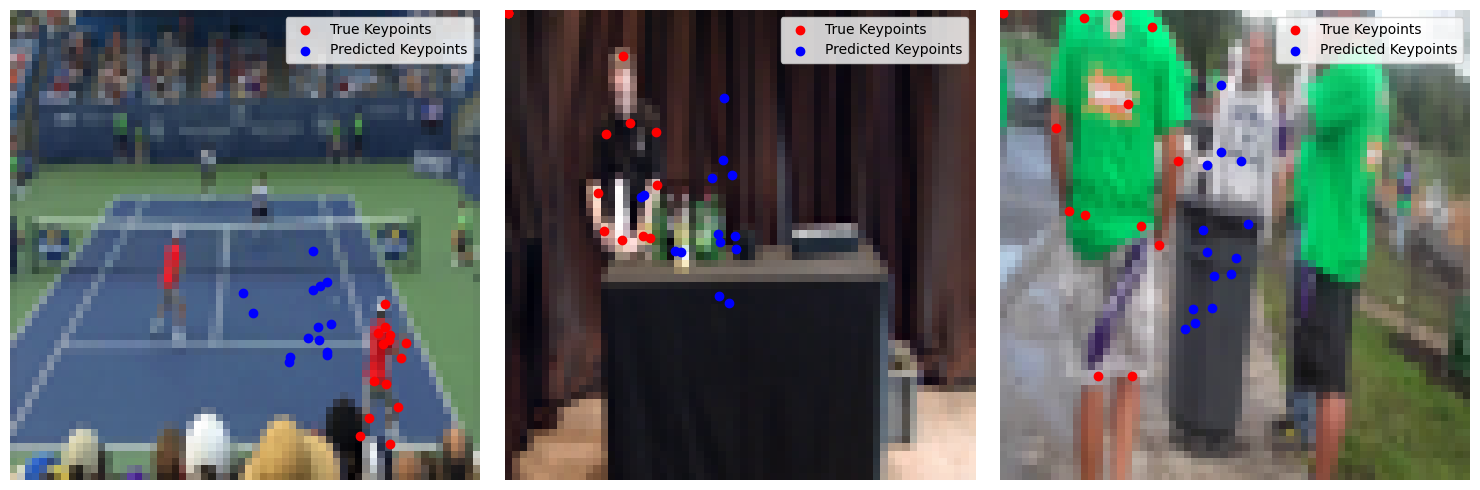

Epoch 36/100 completed in 521.67 seconds
Epoch 37/100


Train Loss: 0.5436
Test Loss: 0.5997, Accuracy: 0.1660


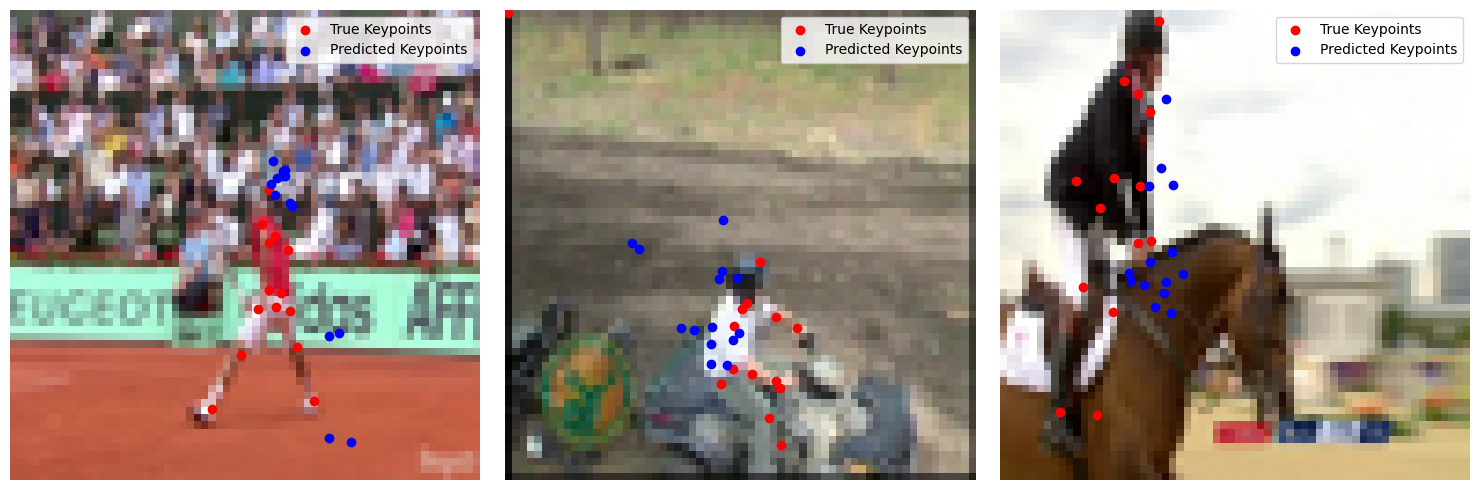

Epoch 37/100 completed in 525.17 seconds
Epoch 38/100


Train Loss: 0.5342
Test Loss: 0.6079, Accuracy: 0.1476


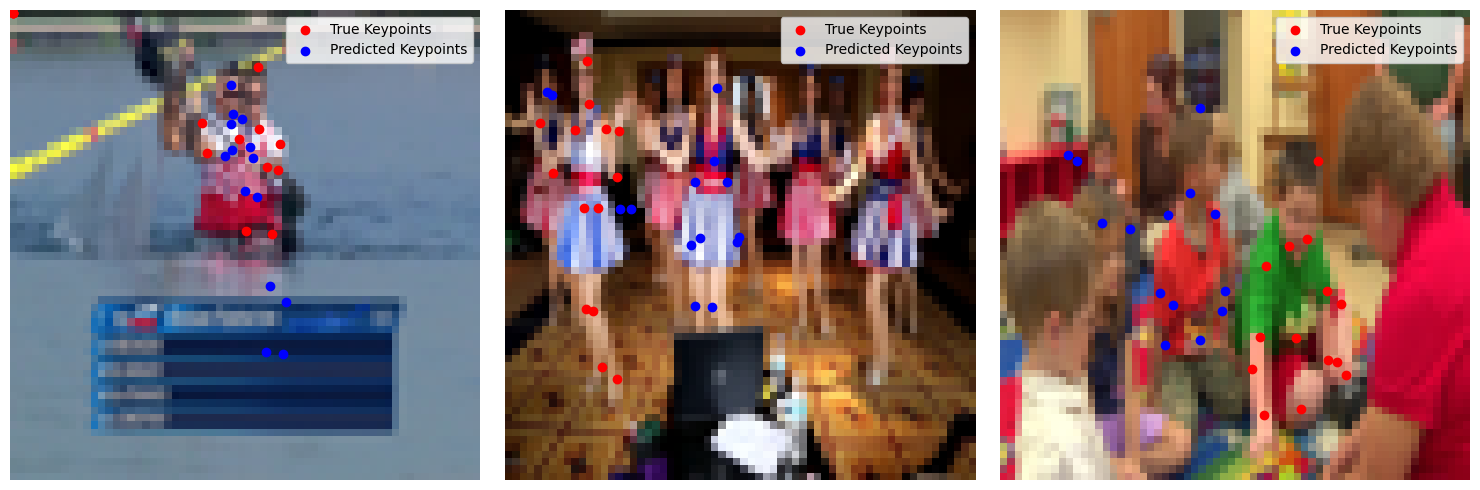

Epoch 38/100 completed in 532.25 seconds
Epoch 39/100


Train Loss: 0.5293
Test Loss: 0.5965, Accuracy: 0.1574


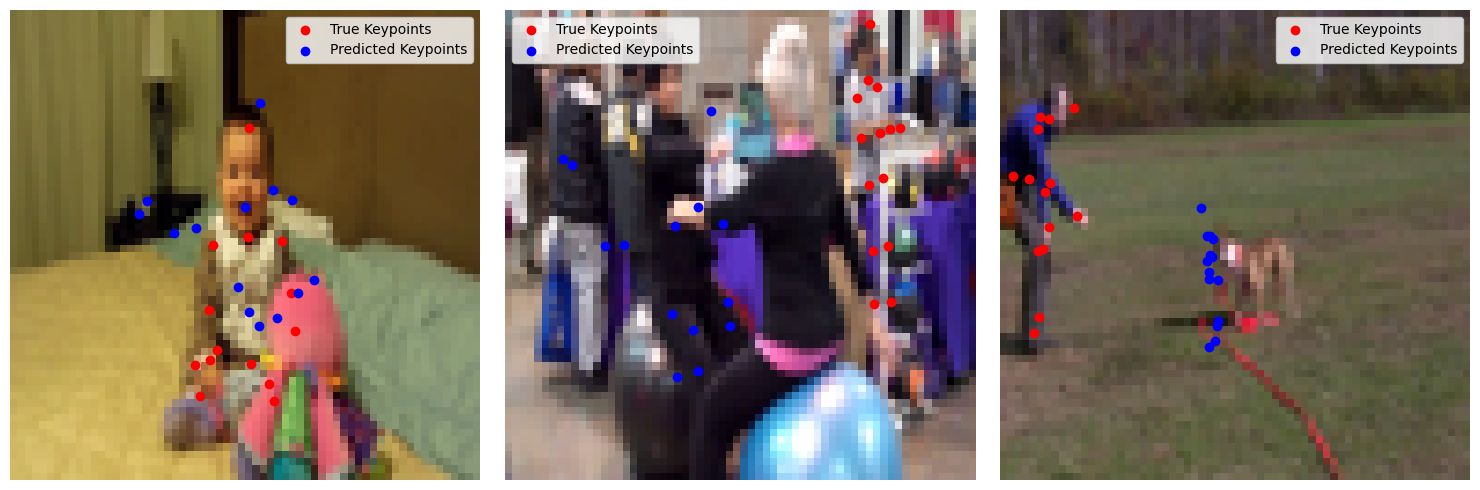

Epoch 39/100 completed in 528.42 seconds
Epoch 40/100


Train Loss: 0.5183
Test Loss: 0.5989, Accuracy: 0.1660


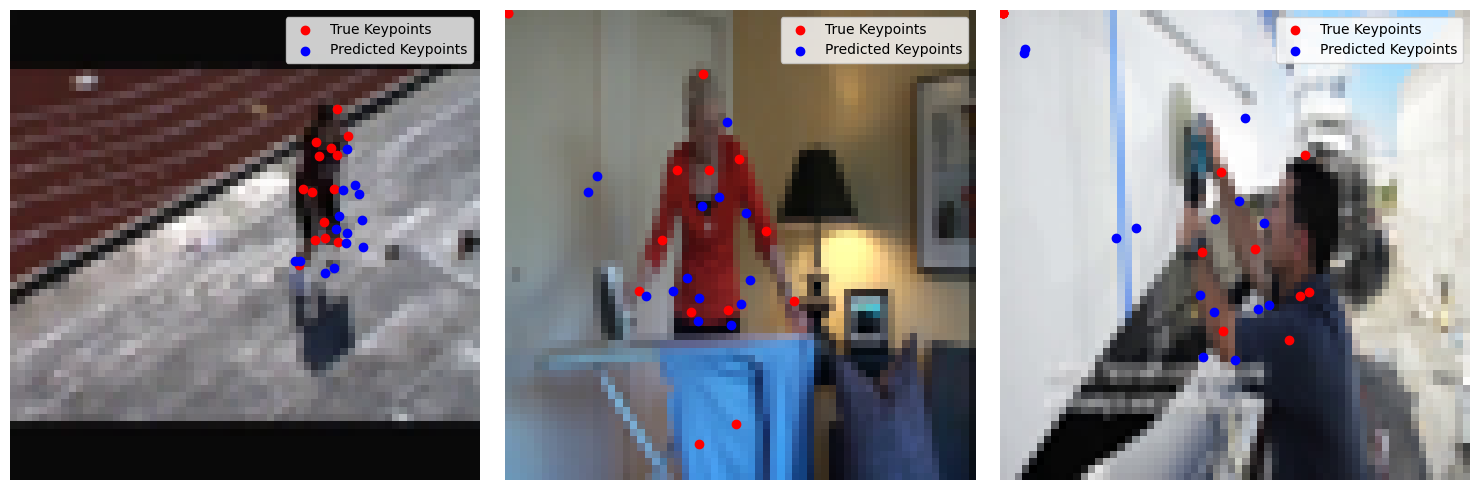

Epoch 40/100 completed in 536.76 seconds
Epoch 41/100


Train Loss: 0.5159
Test Loss: 0.5950, Accuracy: 0.1686


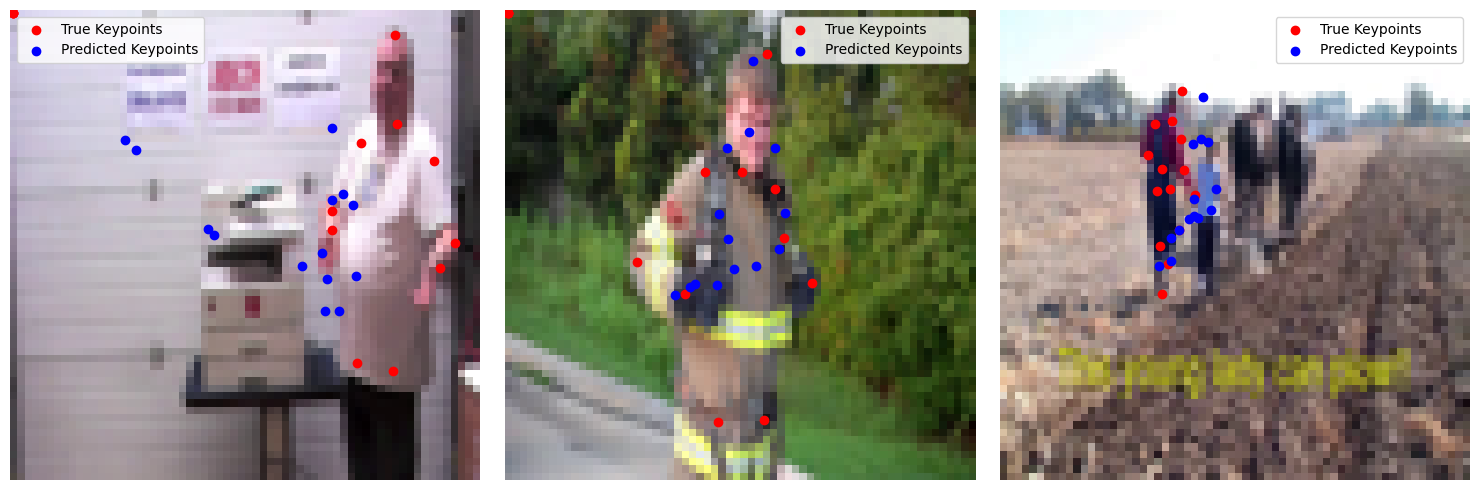

Epoch 41/100 completed in 530.50 seconds
Epoch 42/100


Train Loss: 0.5067
Test Loss: 0.6382, Accuracy: 0.1399


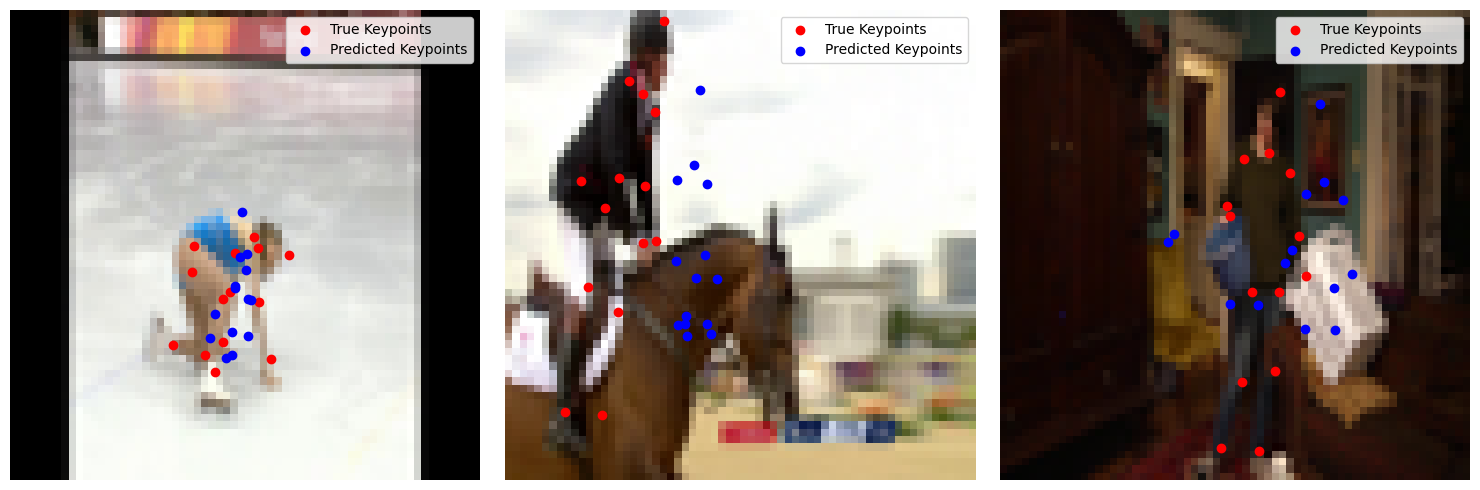

Epoch 42/100 completed in 541.24 seconds
Epoch 43/100


Train Loss: 0.5057
Test Loss: 0.5912, Accuracy: 0.1712


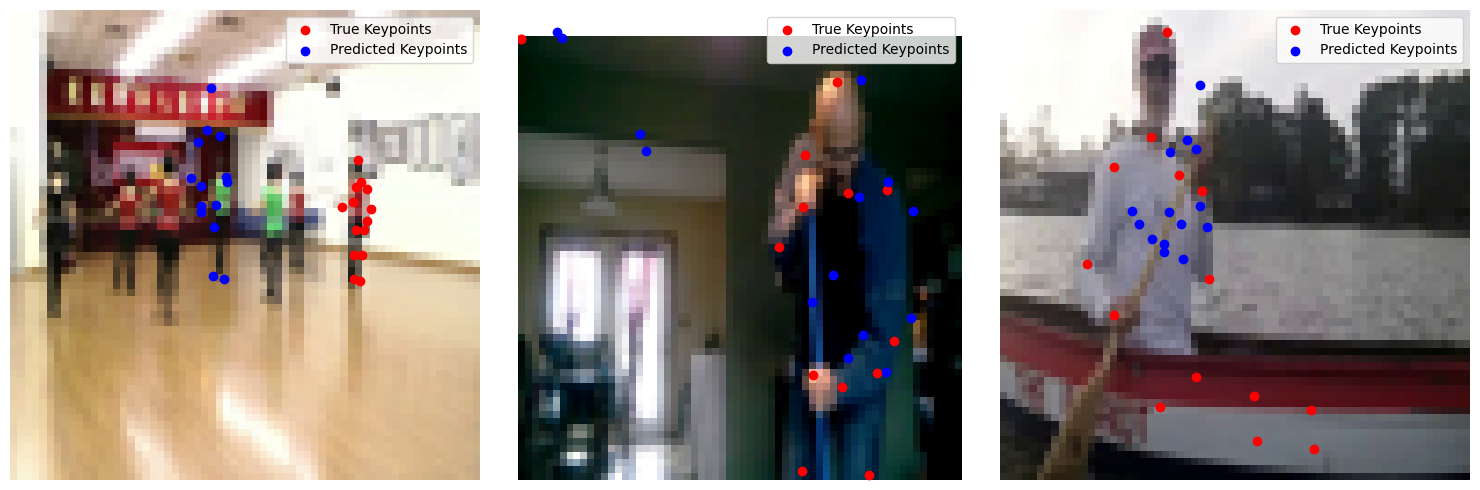

Epoch 43/100 completed in 518.18 seconds
Epoch 44/100


Train Loss: 0.4943
Test Loss: 0.6004, Accuracy: 0.1606


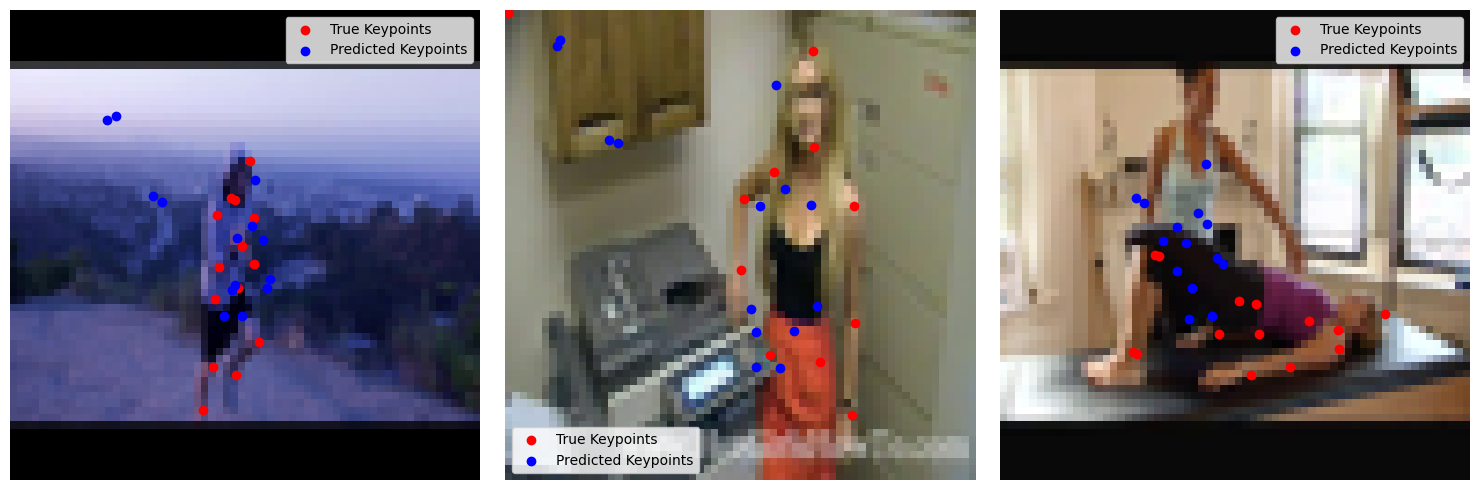

Epoch 44/100 completed in 511.68 seconds
Epoch 45/100


Train Loss: 0.4892
Test Loss: 0.5930, Accuracy: 0.1672


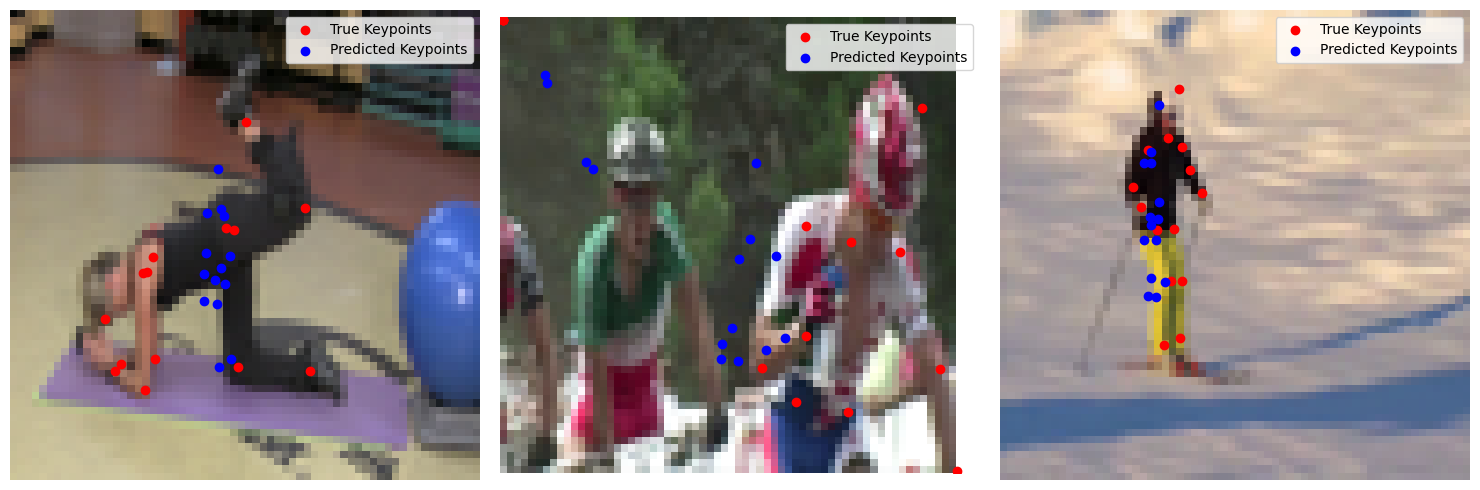

Epoch 45/100 completed in 511.56 seconds
Epoch 46/100


Train Loss: 0.4808
Test Loss: 0.5991, Accuracy: 0.1548


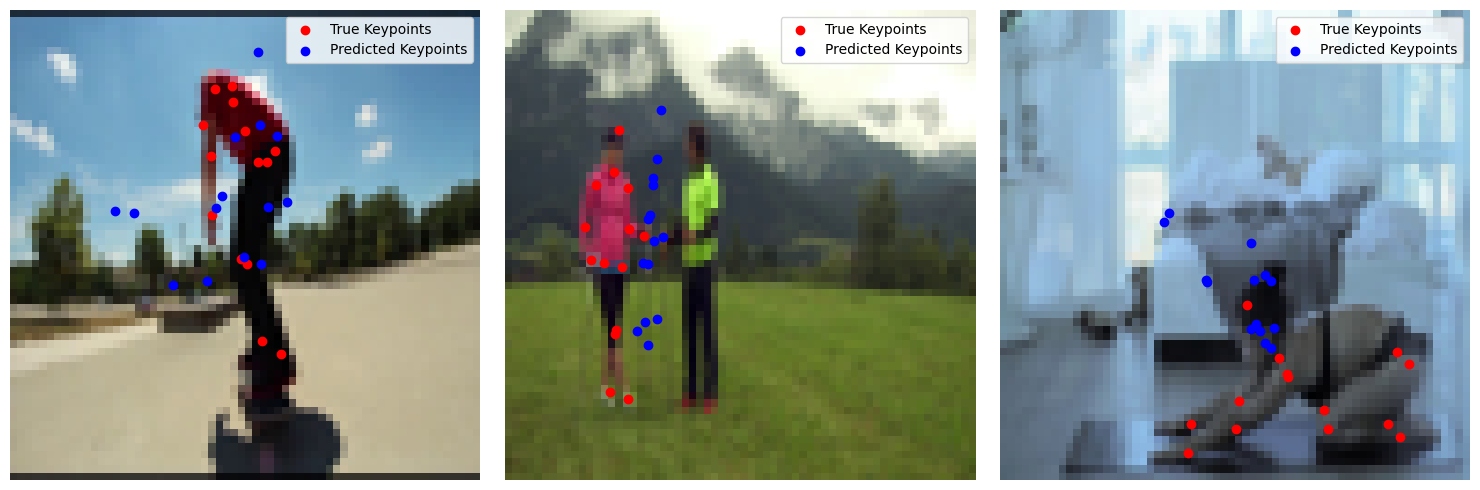

Epoch 46/100 completed in 514.10 seconds
Epoch 47/100


Train Loss: 0.4819
Test Loss: 0.6077, Accuracy: 0.1612


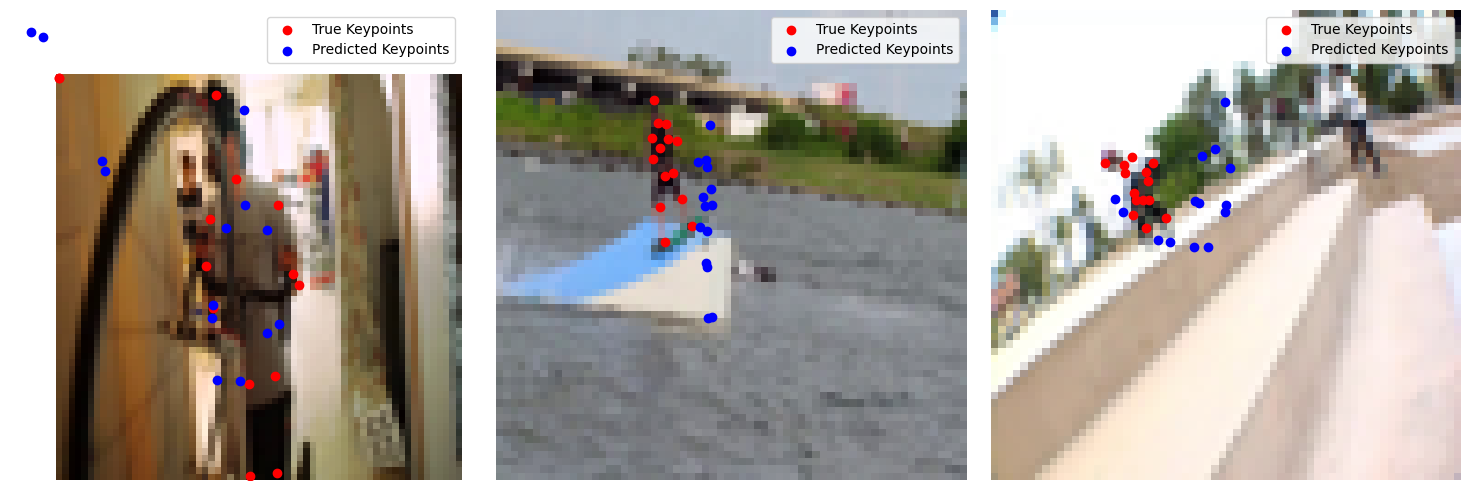

Epoch 47/100 completed in 504.67 seconds
Epoch 48/100


Train Loss: 0.4634
Test Loss: 0.5940, Accuracy: 0.1629


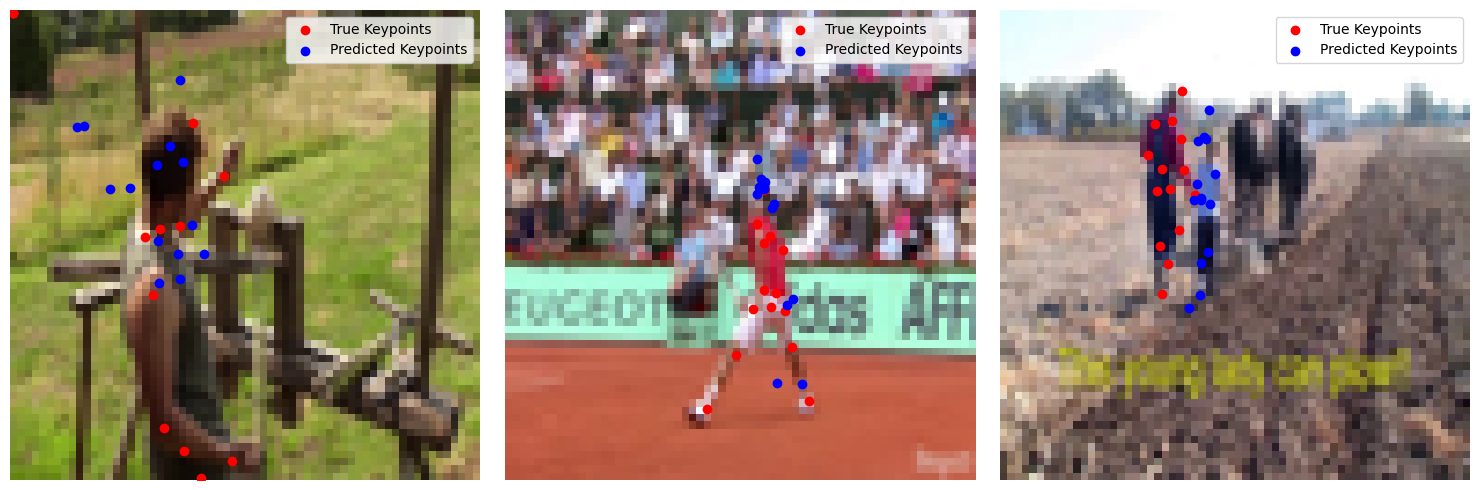

Epoch 48/100 completed in 520.48 seconds
Epoch 49/100


Train Loss: 0.4572
Test Loss: 0.6022, Accuracy: 0.1548


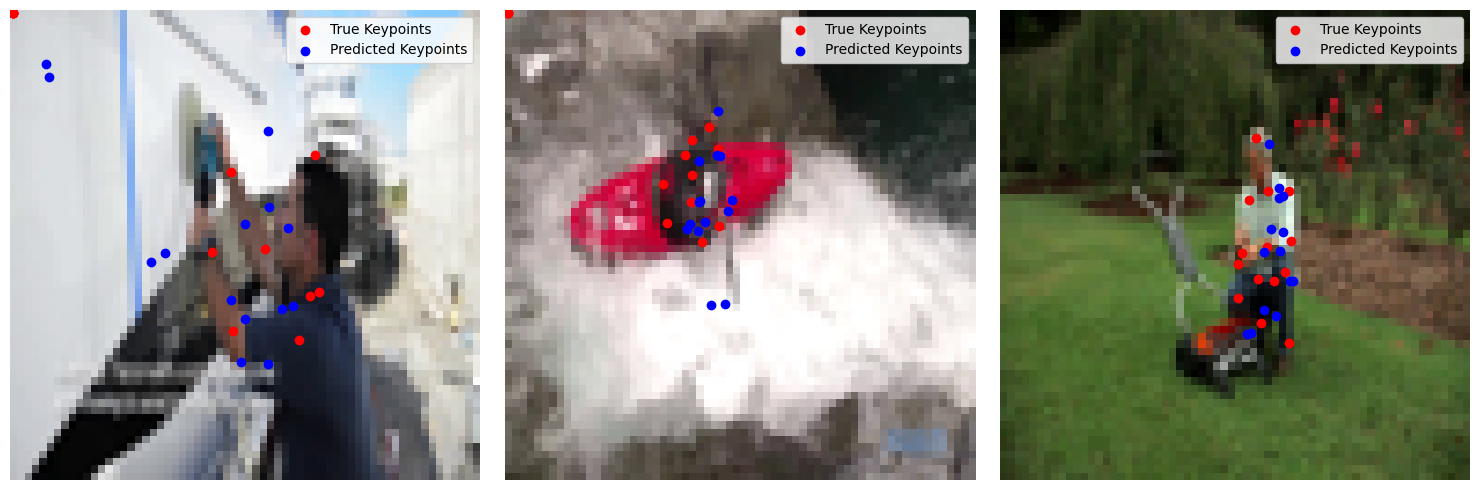

Epoch 49/100 completed in 506.23 seconds
Epoch 50/100


Train Loss: 0.4534
Test Loss: 0.5977, Accuracy: 0.1574


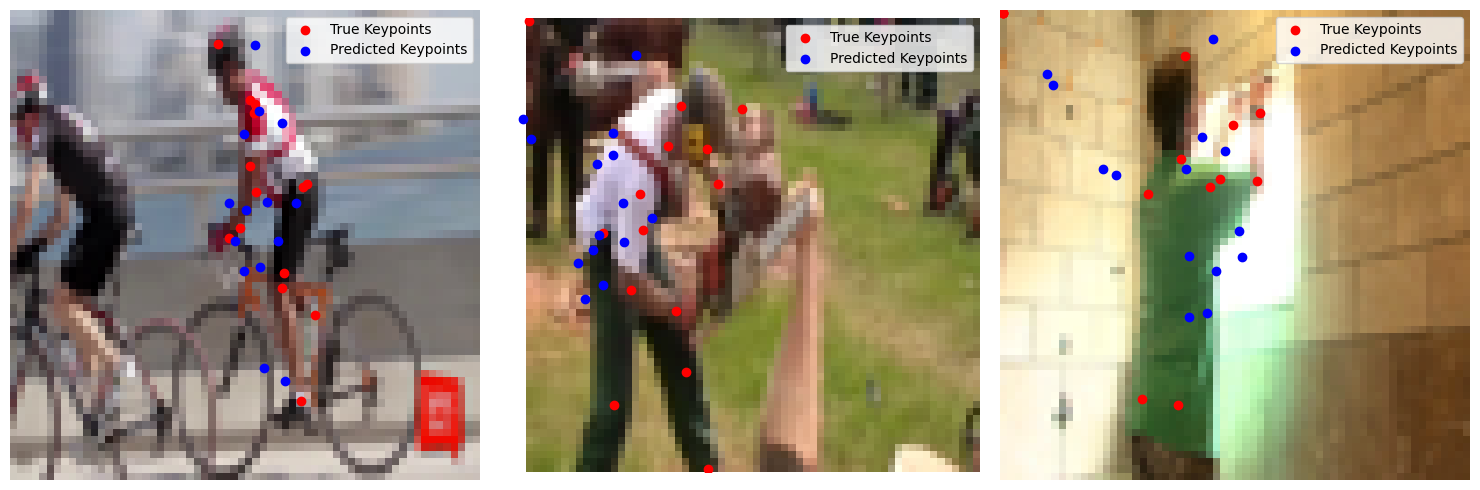

Epoch 50/100 completed in 503.16 seconds
Epoch 51/100


Train Loss: 0.4448
Test Loss: 0.6153, Accuracy: 0.1706


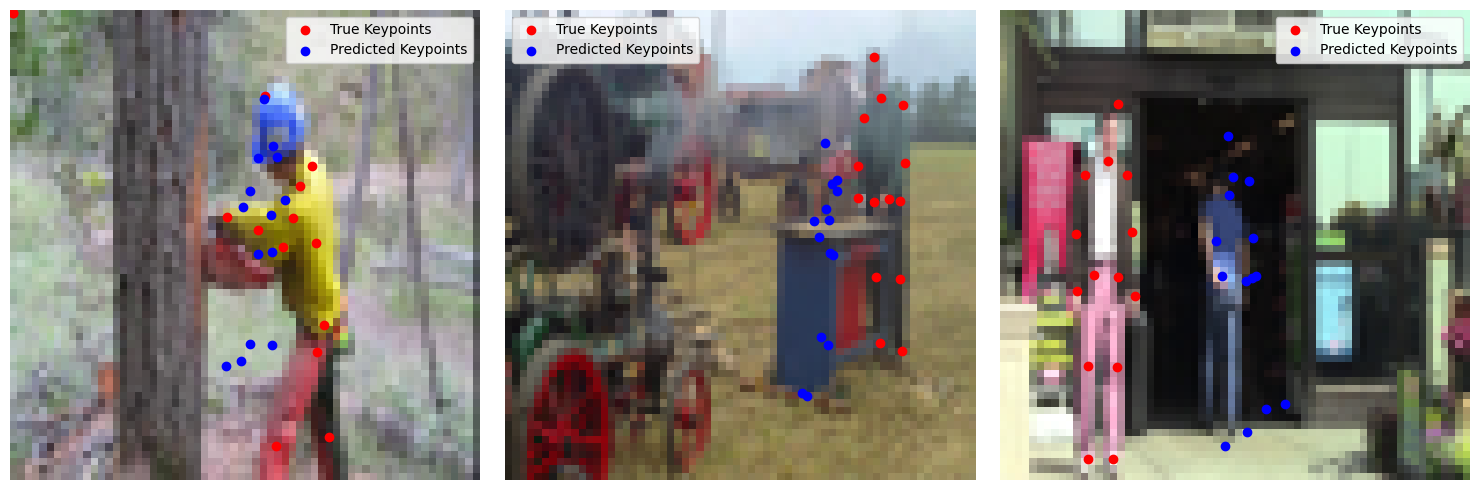

Epoch 51/100 completed in 506.38 seconds
Epoch 52/100


Train Loss: 0.4402
Test Loss: 0.6102, Accuracy: 0.1565


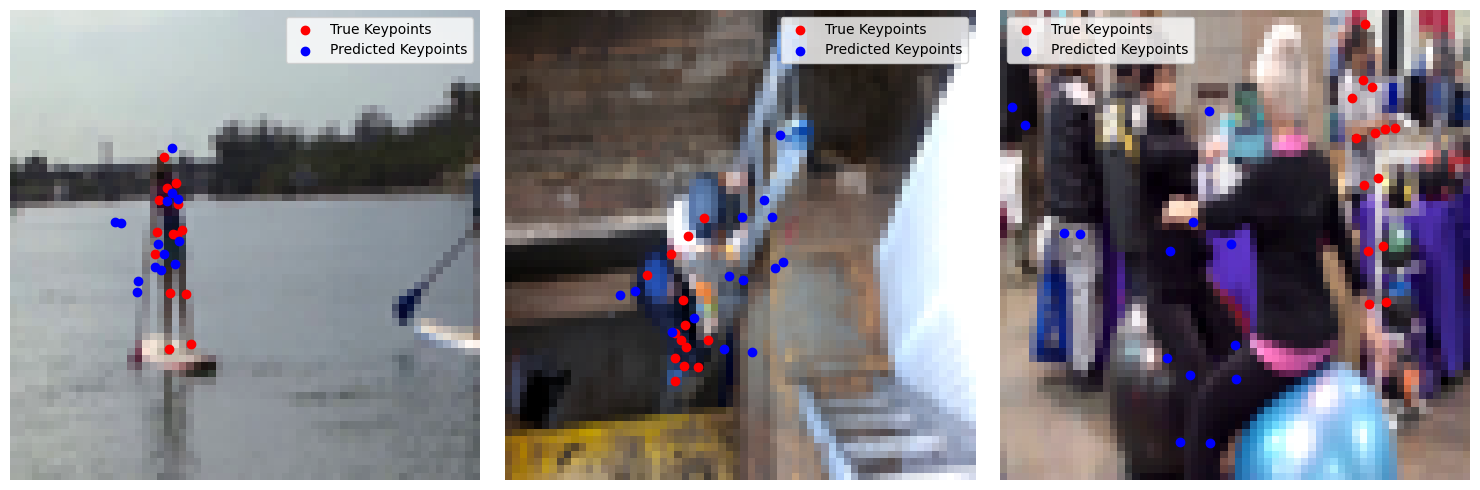

Epoch 52/100 completed in 505.09 seconds
Epoch 53/100


Train Loss: 0.4303
Test Loss: 0.6280, Accuracy: 0.1698


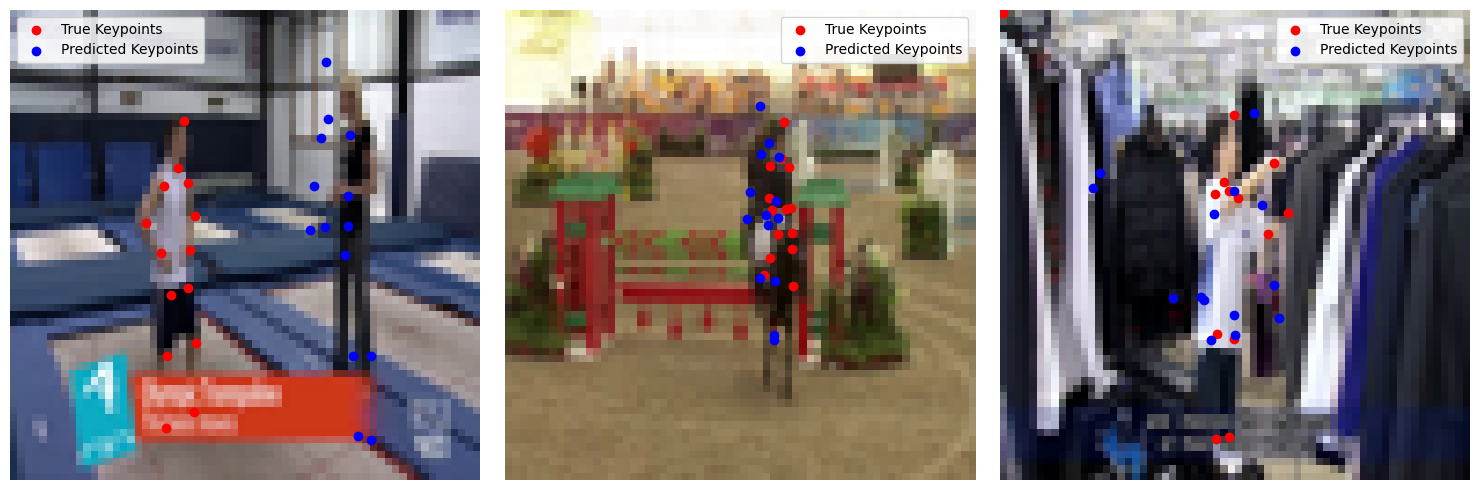

Epoch 53/100 completed in 504.65 seconds
Epoch 54/100


Train Loss: 0.4244
Test Loss: 0.6084, Accuracy: 0.1718


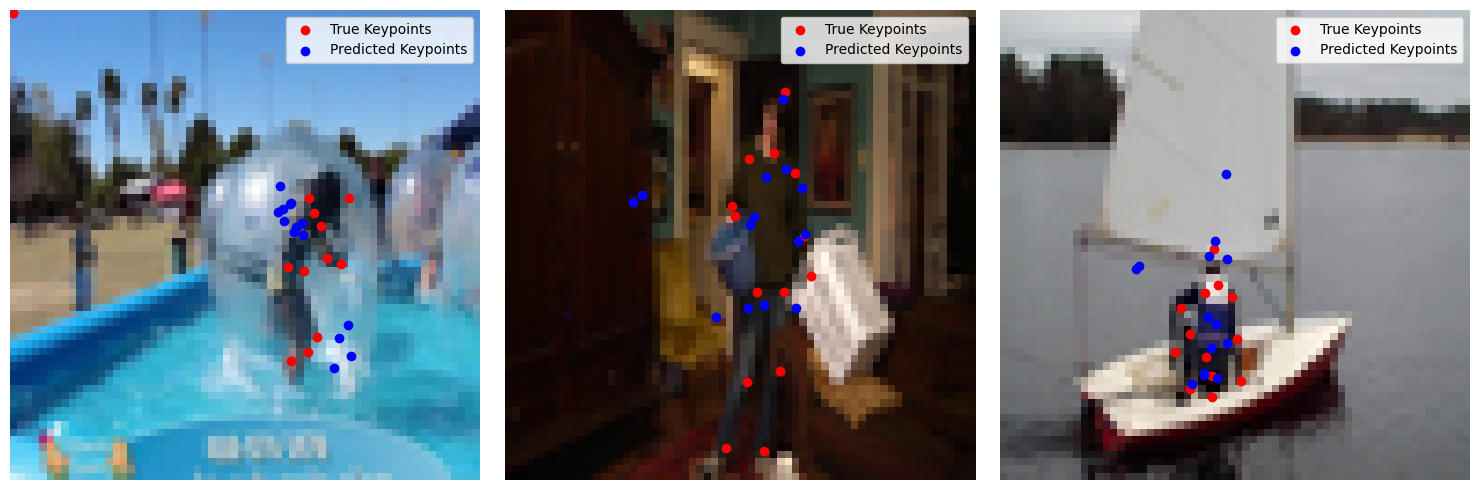

Epoch 54/100 completed in 504.29 seconds
Epoch 55/100


Train Loss: 0.4190
Test Loss: 0.6016, Accuracy: 0.1681


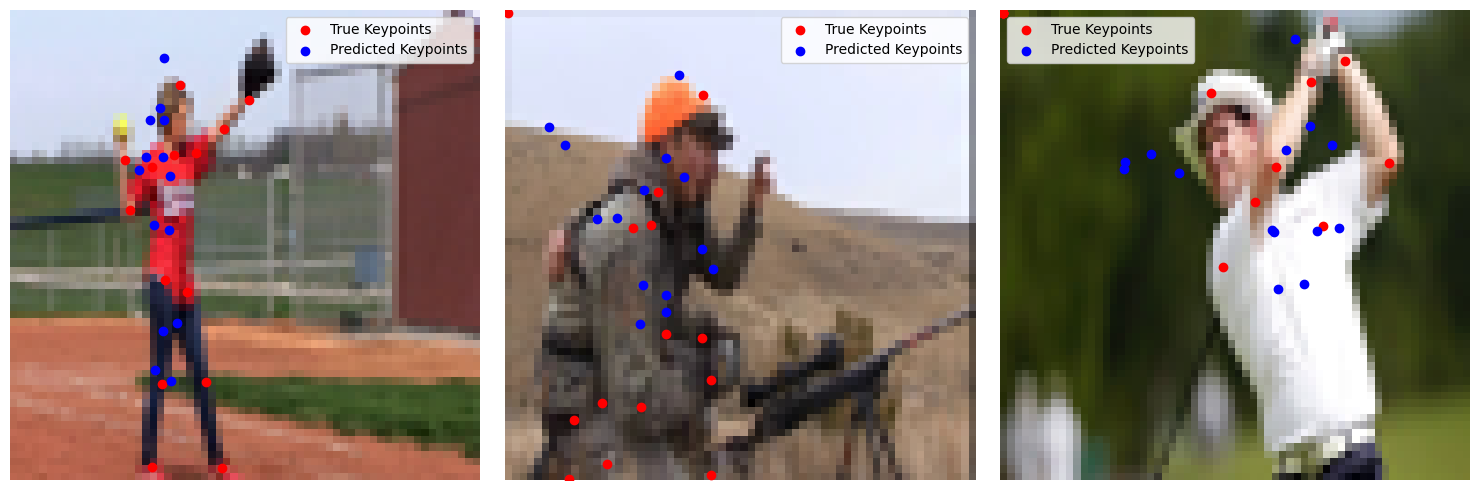

Epoch 55/100 completed in 520.94 seconds
Epoch 56/100


Train Loss: 0.4094
Test Loss: 0.6053, Accuracy: 0.1738


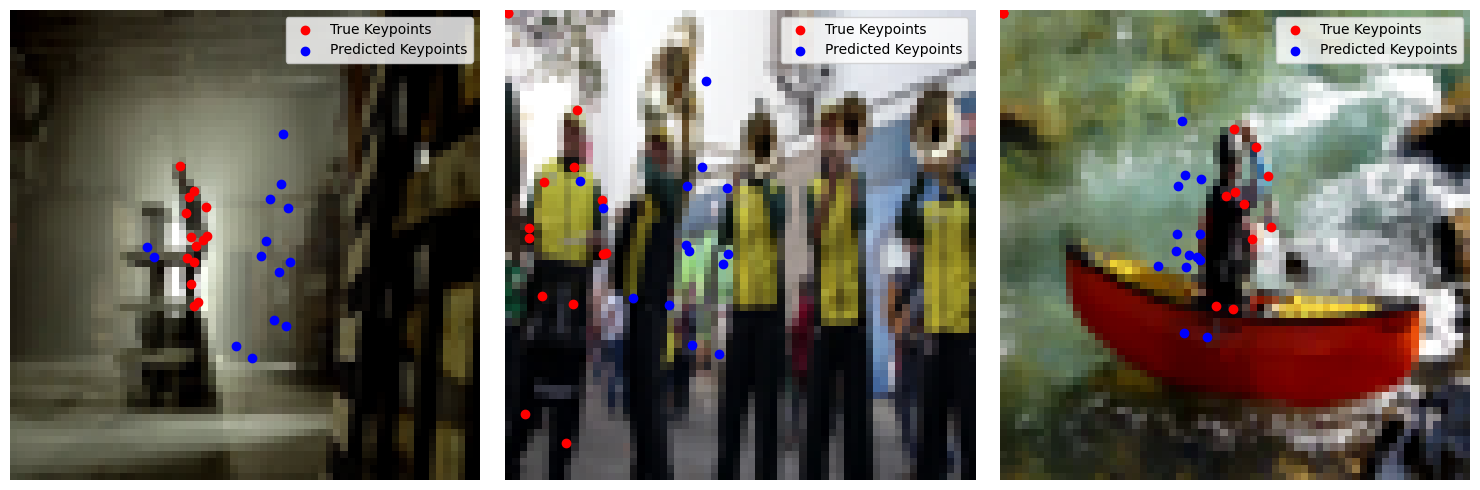

Epoch 56/100 completed in 586.55 seconds
Epoch 57/100


Train Loss: 0.4035
Test Loss: 0.6079, Accuracy: 0.1796


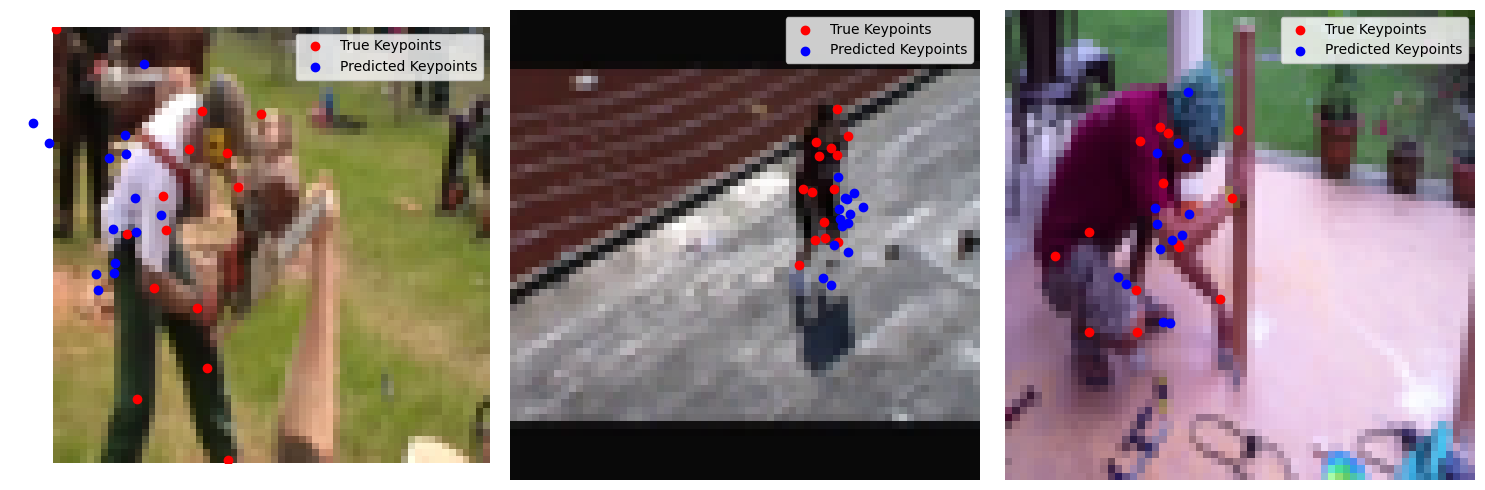

Epoch 57/100 completed in 506.59 seconds
Epoch 58/100


Train Loss: 0.3955
Test Loss: 0.6686, Accuracy: 0.1499


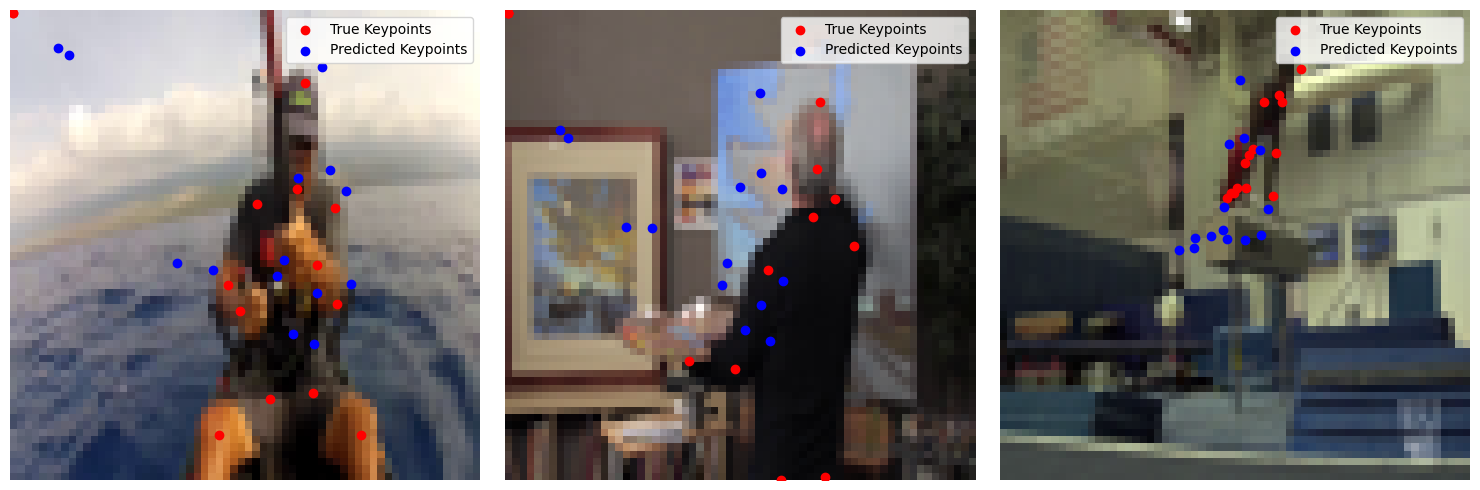

Epoch 58/100 completed in 534.72 seconds
Epoch 59/100


Train Loss: 0.3975
Test Loss: 0.6115, Accuracy: 0.1741


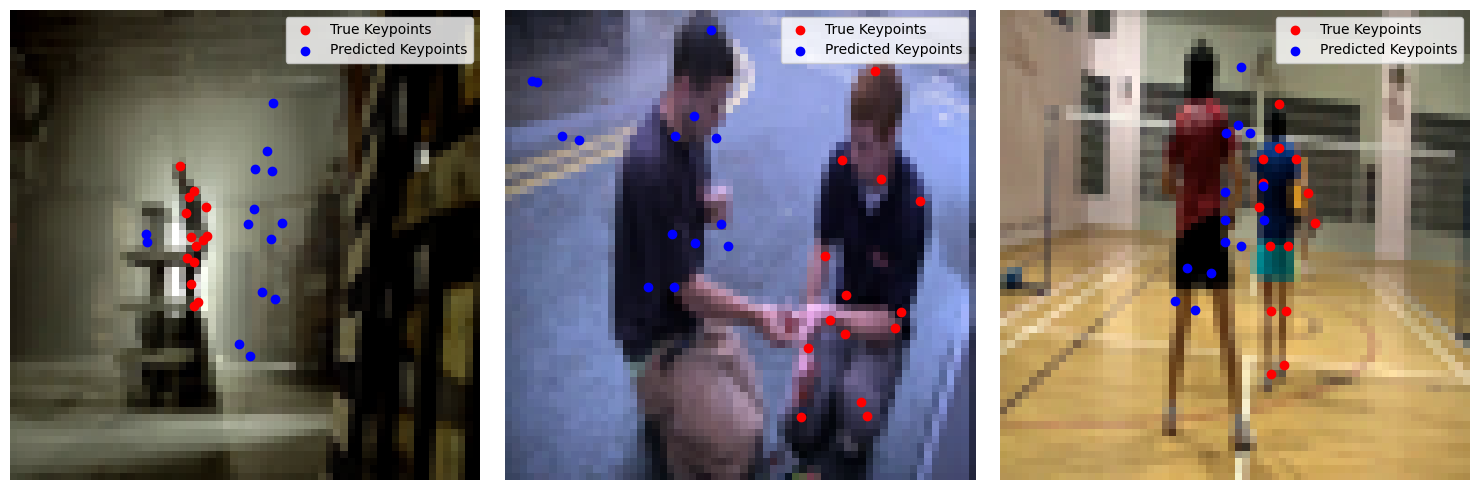

Epoch 59/100 completed in 656.52 seconds
Epoch 60/100


Train Loss: 0.3840
Test Loss: 0.6132, Accuracy: 0.1669


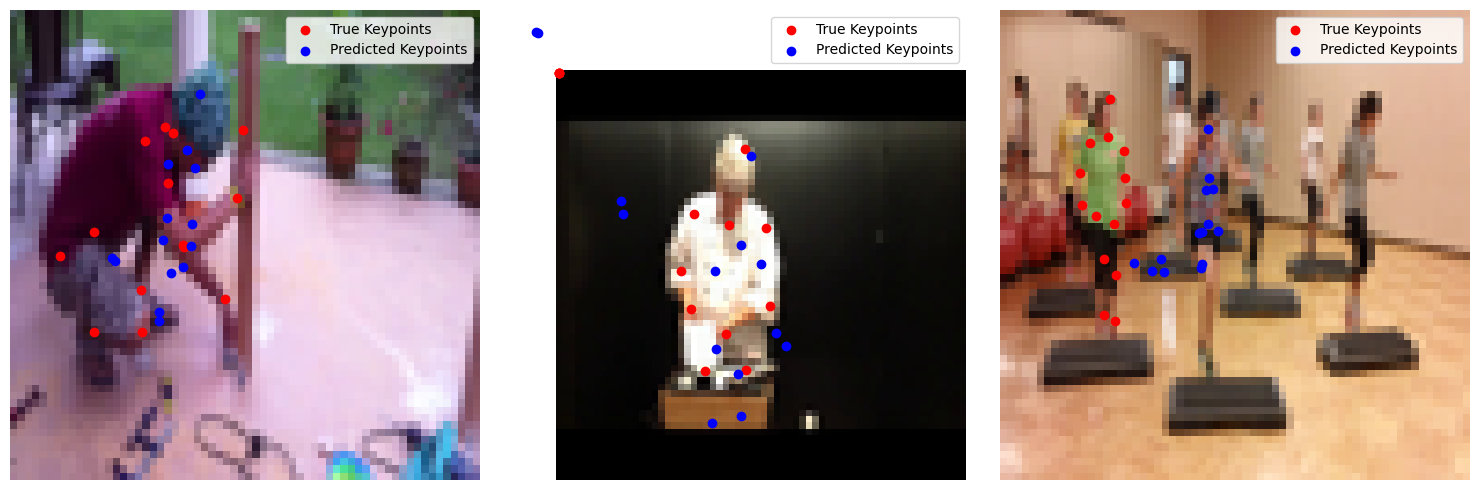

Epoch 60/100 completed in 503.73 seconds
Epoch 61/100


Train Loss: 0.3734
Test Loss: 0.6161, Accuracy: 0.1606


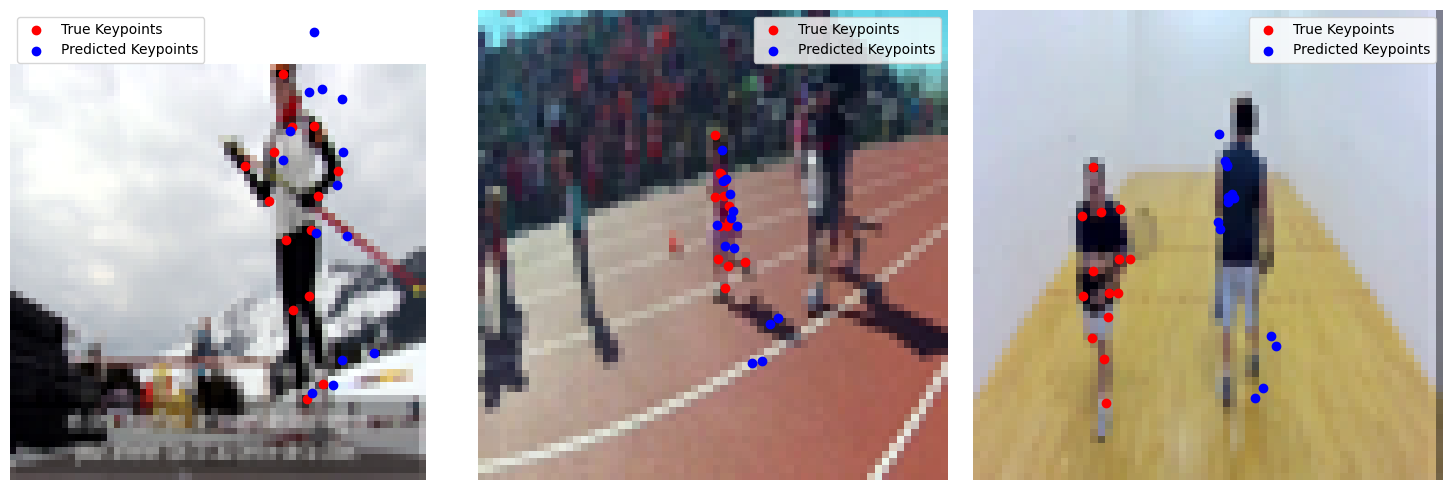

Epoch 61/100 completed in 505.18 seconds
Epoch 62/100


Train Loss: 0.3658
Test Loss: 0.6285, Accuracy: 0.1683


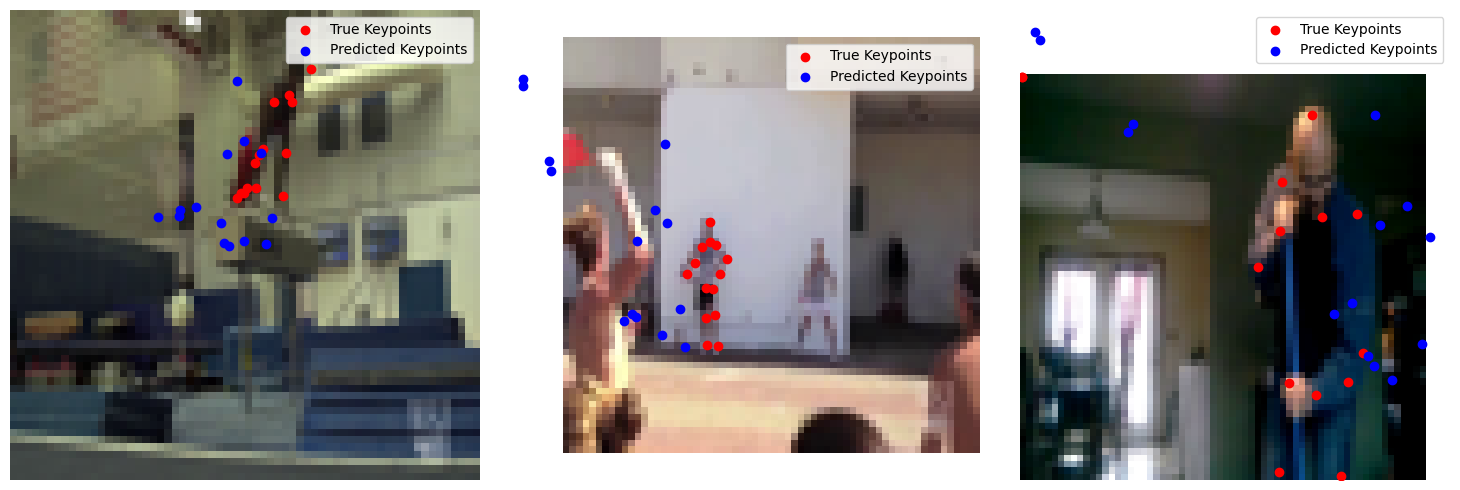

Epoch 62/100 completed in 517.96 seconds
Epoch 63/100


Train Loss: 0.3629
Test Loss: 0.6265, Accuracy: 0.1600


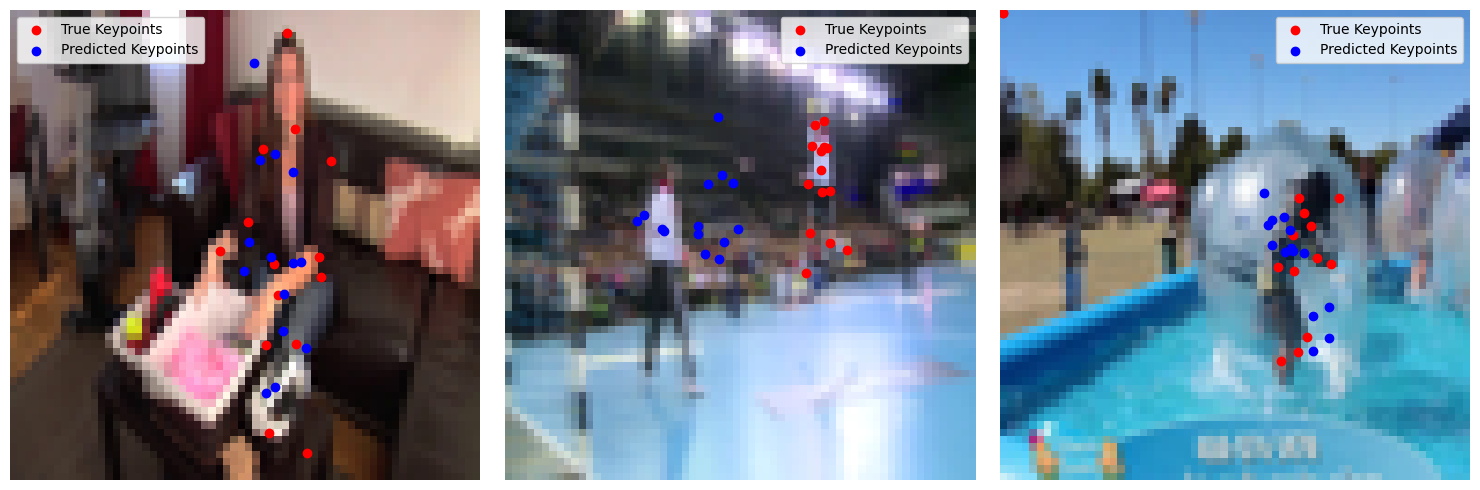

Epoch 63/100 completed in 507.95 seconds
Epoch 64/100


Train Loss: 0.3539
Test Loss: 0.6278, Accuracy: 0.1614


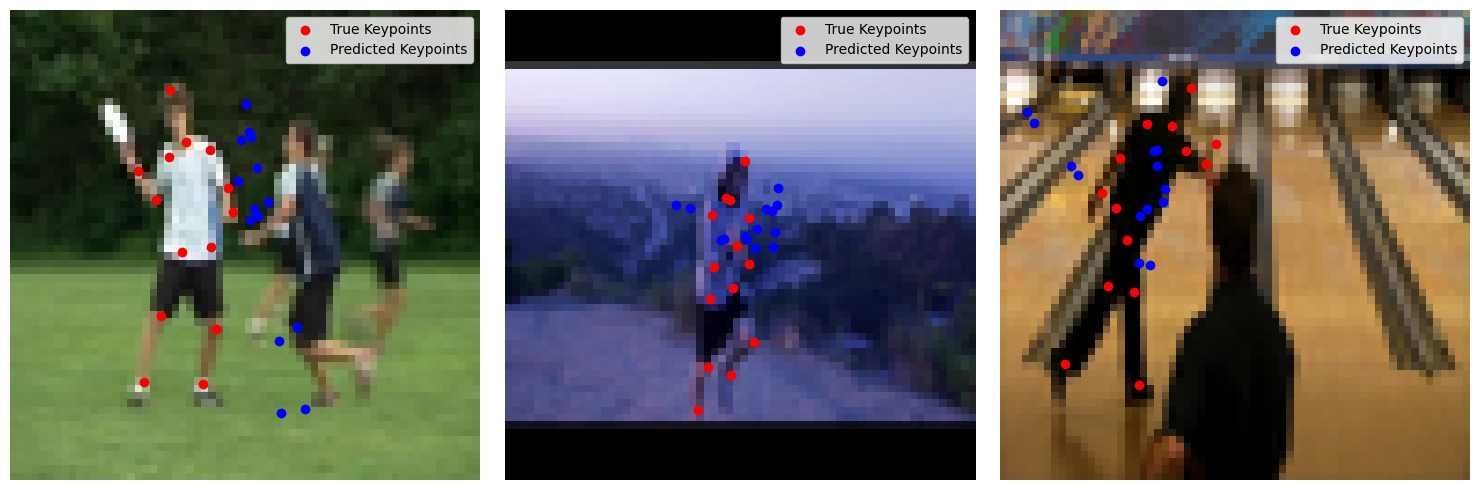

Epoch 64/100 completed in 504.79 seconds
Epoch 65/100


Train Loss: 0.3520
Test Loss: 0.6347, Accuracy: 0.1623


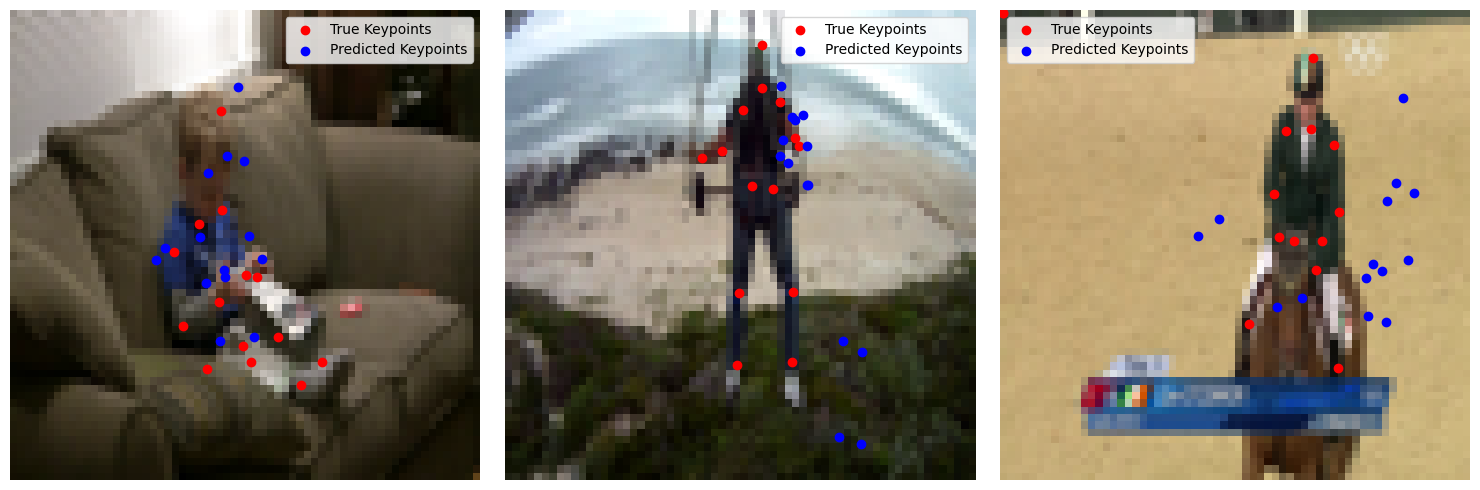

Epoch 65/100 completed in 512.54 seconds
Epoch 66/100


Train Loss: 0.3427
Test Loss: 0.6375, Accuracy: 0.1695


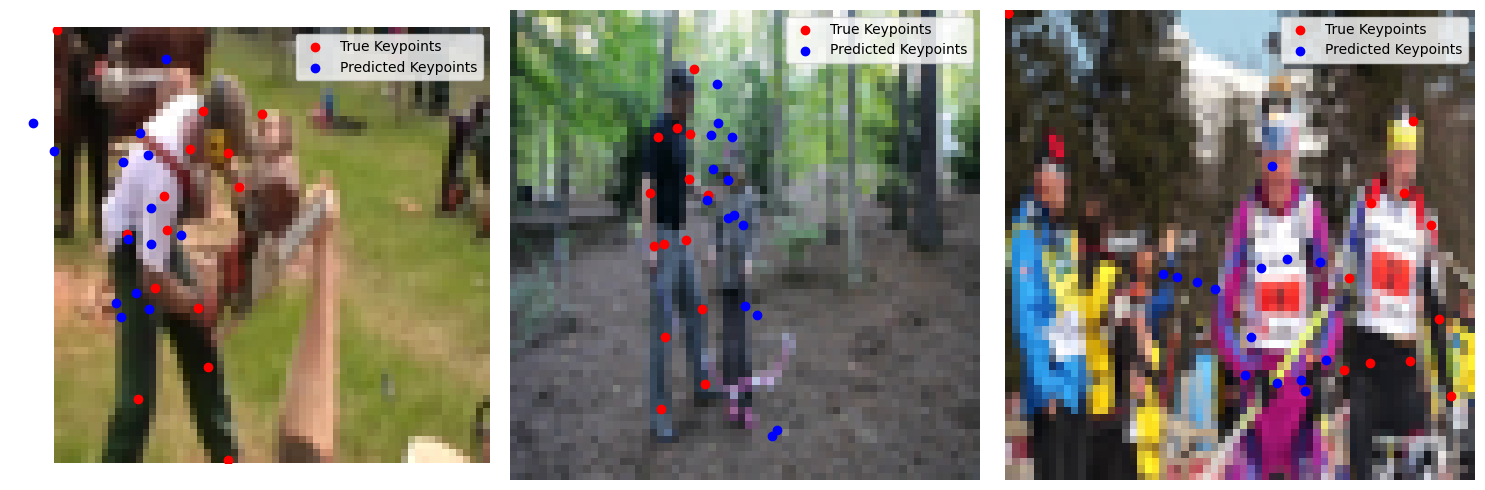

Epoch 66/100 completed in 513.11 seconds
Epoch 67/100


Train Loss: 0.3334
Test Loss: 0.6243, Accuracy: 0.1747


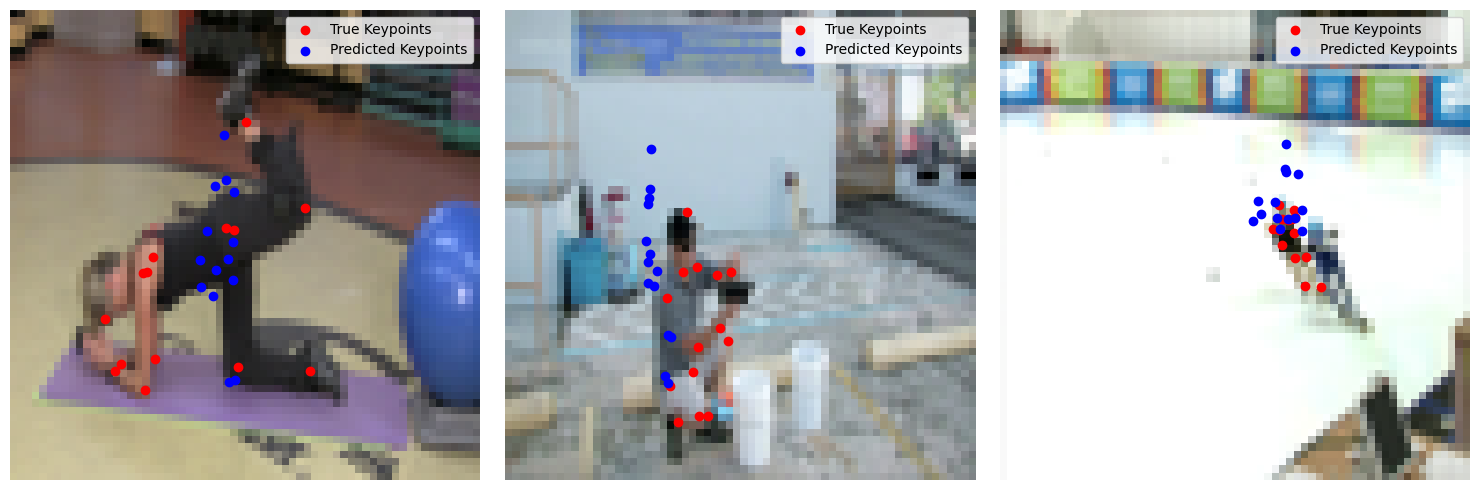

Epoch 67/100 completed in 515.28 seconds
Epoch 68/100


Train Loss: 0.3291
Test Loss: 0.6264, Accuracy: 0.1709


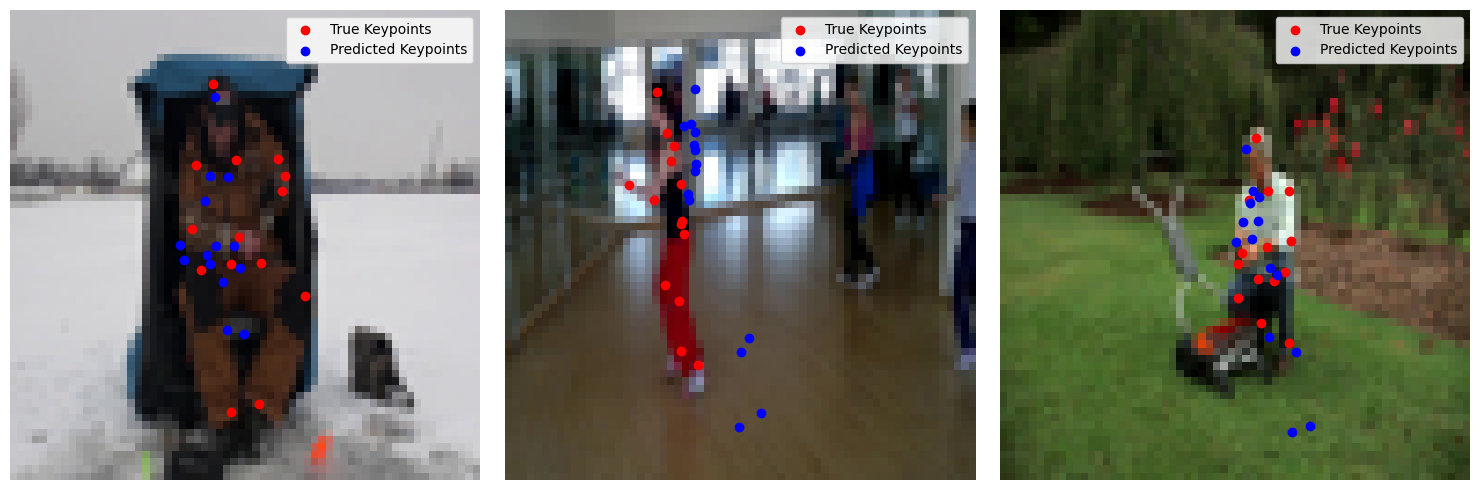

Epoch 68/100 completed in 513.05 seconds
Epoch 69/100


Training:  64%|██████▎   | 35/55 [04:23<02:30,  7.54s/it]

In [ ]:
class KeypointLoss(nn.Module):
    def forward(self, preds, keypoints):
        with torch.no_grad():
            mask = 1 - (keypoints == -1).float()
        
        distances = torch.square(preds - keypoints) * mask
        return distances.mean()

model = MyPoseNet()
criterion = KeypointLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=100, device='cuda' if torch.cuda.is_available() else 'cpu')
